In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import igrins_mod as ig # Custom module file for igrins shenanigans

import glob
import os
import warnings

import astropy.units as u
# from astropy.modeling import models, fitting
from astroquery.nist import Nist # atomic lines
# from astroquery.linelists.cdms import CDMS # molecular lines?

# from specutils import Spectrum1D
# from specutils.fitting import fit_generic_continuum

from scipy.integrate import trapz
from scipy.optimize import curve_fit
from scipy.signal import medfilt

# from astropy.io import ascii
from astropy.io import fits


%matplotlib inline

# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18

plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20

plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

# Things that should only have to be defined once, here at the top
---

In [2]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

c = 299792458 # speed of light m/s
# Use Normalized (single) Gaussian Distribution
def gaussian_func(x,ampl,center,std):
    return ((ampl)/(std*np.sqrt(2*np.pi)) * np.exp(-0.5*((x - center)/std)**2)) + 1

# Reduced and order-merged data filepath 
# Desktop path
# data_path = "A:\\Documents/Grad_School/IGRINS-Spectra/IGRINS_Merged"

# Laptop Path
data_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-Spectra\\IGRINS_Merged"
# File path for figures to live in
# Desktop path
# fig_path = "A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_figs/standards_spectra"

# Laptop Path
fig_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-SpectraIGRINS_figs\\standards_spectra"


# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path+"/merged_standards/m*.fits")
standard_table = pd.read_csv('./standard_table_v2.txt') # csv of standards with file and Spectral Type, c/v TBA

standard_shift = standard_table['Wavelength Shift']
standard_list = standard_table['Source']

hops_table = pd.read_csv('./hops_table.txt')
hops_list = hops_table['Source']

# Determine the maximum length of flux arrays for the standards
max_flux_length = max(len(fits.getdata(file)[1]) for file in standard_list)
max_wavelen_length = max(len(fits.getdata(file)[0]) for file in standard_list)
max_snr_length = max(len(fits.getdata(file)[2]) for file in standard_list)

# Initialize flux_stack with NaN values
wavelen_stack = np.full((max_wavelen_length, len(standard_list)), np.nan)
raw_flux_stack = np.full((max_flux_length, len(standard_list)), np.nan)
flux_stack = np.full((max_flux_length, len(standard_list)), np.nan)
snr_stack = np.full((max_snr_length, len(standard_list)), np.nan)

# Fill flux_stack with flux data
for i, file in enumerate(standard_list):
    # Get data
    wavelen = fits.getdata(file)[0]
    flux = fits.getdata(file)[1]
    median_flux = medfilt(flux, kernel_size=101)
    norm_flux = flux/median_flux

    snr = fits.getdata(file)[2]
    # Clean data a bit
    snr_min = 10 # Minimum SNR
    snr_max = 1e4 # Maxmimum SNR
    snr_cut = (snr > snr_min) & (snr < snr_max) # bitwise SNR masking

    flux_min = 0 # minimum flux
    flux_cut = flux > flux_min # bitwise flux masking

    wavelen_min = 2.0
    wavelen_max = 2.3
    wavelen_cut = (wavelen > wavelen_min) & (wavelen < wavelen_max)

    # Apply masks and remove NaNs and infs
    # snr_cut & 
    mask = flux_cut & wavelen_cut
    wavelen = wavelen[mask]
    flux = flux[mask]
    snr = snr[mask]
    norm_flux = norm_flux[mask]

    # Remove NaNs and infs from wavelen and norm_flux arrays
    valid_indices = ~np.isnan(wavelen) & ~np.isinf(wavelen) & ~np.isnan(norm_flux) & ~np.isinf(norm_flux) & ~np.isnan(flux) & ~np.isinf(flux) & ~np.isnan(snr) & ~np.isinf(snr)
    
    wavelen = wavelen[valid_indices] - standard_shift[i]
    flux = flux[valid_indices]
    norm_flux = norm_flux[valid_indices]
    snr = snr[valid_indices]

    wavelen_stack[:len(wavelen), i] = wavelen  # Wavelength arrays for each standard
    raw_flux_stack[:len(flux), i] = flux
    snr_stack[:len(snr),i] = snr
    flux_stack[:len(norm_flux), i] = norm_flux  # Normalized flux arrays for each standard

# Determine the maximum length of flux arrays for the protostars
max_flux_length = max(len(fits.getdata(file)[1]) for file in hops_list)
max_wavelen_length = max(len(fits.getdata(file)[0]) for file in hops_list)
max_snr_length = max(len(fits.getdata(file)[2]) for file in hops_list)
# Initialize flux_stack with NaN values

hops_wavelen_stack = np.full((max_wavelen_length, len(hops_list)), np.nan)
hops_flux_stack = np.full((max_flux_length, len(hops_list)), np.nan)
hops_snr_stack = np.full((max_snr_length, len(hops_list)), np.nan)

# Fill flux_stack with flux data
# for i, file in enumerate(hops_list):
#     # Get data
#     wavelen = fits.getdata(file)[0]
#     flux = fits.getdata(file)[1]
#     snr = fits.getdata(file)[2] # snr per resolution element I think

#     median_flux = medfilt(flux, kernel_size=51)
#     norm_flux = flux/median_flux

#     # Clean data a bit
#     snr_min = 5 # Minimum SNR
#     snr_max = 1e4 # Maxmimum SNR
#     snr_cut = (snr > snr_min) & (snr < snr_max) # bitwise SNR masking

#     flux_min = 0 # minimum flux
#     flux_cut = flux > flux_min # bitwise flux masking

#     wavelen_min = 2.0
#     wavelen_max = 2.48
#     wavelen_cut = (wavelen > wavelen_min) & (wavelen < wavelen_max)

#     wavelen = wavelen[snr_cut & flux_cut & wavelen_cut]
#     norm_flux = norm_flux[snr_cut & flux_cut  & wavelen_cut]
#     snr = snr[snr_cut & flux_cut  & wavelen_cut]

#     hops_wavelen_stack[:len(wavelen),i] = wavelen # wavelength arrays for each standard
#     hops_flux_stack[:len(norm_flux),i] = norm_flux # normalized flux arrays for each standard 

#     snr_stack[:len(snr),i] = snr

# Directly query NIST to find line features in K-band
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore') 
    lines_table = Nist.query(2.2*u.um,2.3*u.um,
                    linename = 'Na I, Sc I, Si I, Fe I,Fe II, Al I, Mg I, Ca I, H I, Ti I',
                    energy_level_unit='eV',output_order='wavelength')
igrins_wav_cut = (lines_table['Observed'] > 2.2) & (lines_table['Observed'] < 2.3)

lines_table = lines_table[igrins_wav_cut]
# Make masks for the table of all the lines just in case I want to peek at certain transitions/wavelengths
na1_mask = lines_table['Spectrum'] == 'Na I'
sc1_mask = lines_table['Spectrum'] == 'Sc I'
si1_mask = lines_table['Spectrum'] == 'Si I'
fe1_mask = lines_table['Spectrum'] == 'Fe I'
fe2_mask = lines_table['Spectrum'] == 'Fe II'
al1_mask = lines_table['Spectrum'] == 'Al I'
mg1_mask = lines_table['Spectrum'] == 'Mg I'
ca1_mask = lines_table['Spectrum'] == 'Ca I'
h1_mask  = lines_table['Spectrum'] == 'H I'
ti1_mask = lines_table['Spectrum'] == 'Ti I'

# Just add all the masks to a list for the sake of my plotting a few cells down
mask_list = [na1_mask,sc1_mask,si1_mask,fe1_mask,al1_mask,mg1_mask,ca1_mask,h1_mask,ti1_mask]
color_list = ['purple', 'orange', 'green', 'blue', 'brown', 'crimson', 'olive', 'cyan', 'darkgreen']

C:\Users\Savio\AppData\Local\Temp\ipykernel_26320\2833525370.py:55: RuntimeWarning: divide by zero encountered in divide
  norm_flux = flux/median_flux


# Temperature Sensitive Lines

Sc I (2.2058 $\mu m$ and 2.2071 $\mu m$)

Si I (2.2068 $\mu m$)

Fe I (2.2205–2.2346 $\mu m$) Over Ti region

Ca I (2.2614, 2.2631, 2.2657 $\mu m$)

# Gaussian Fitting to Na I (2.2062) & Sc I (2.2058)

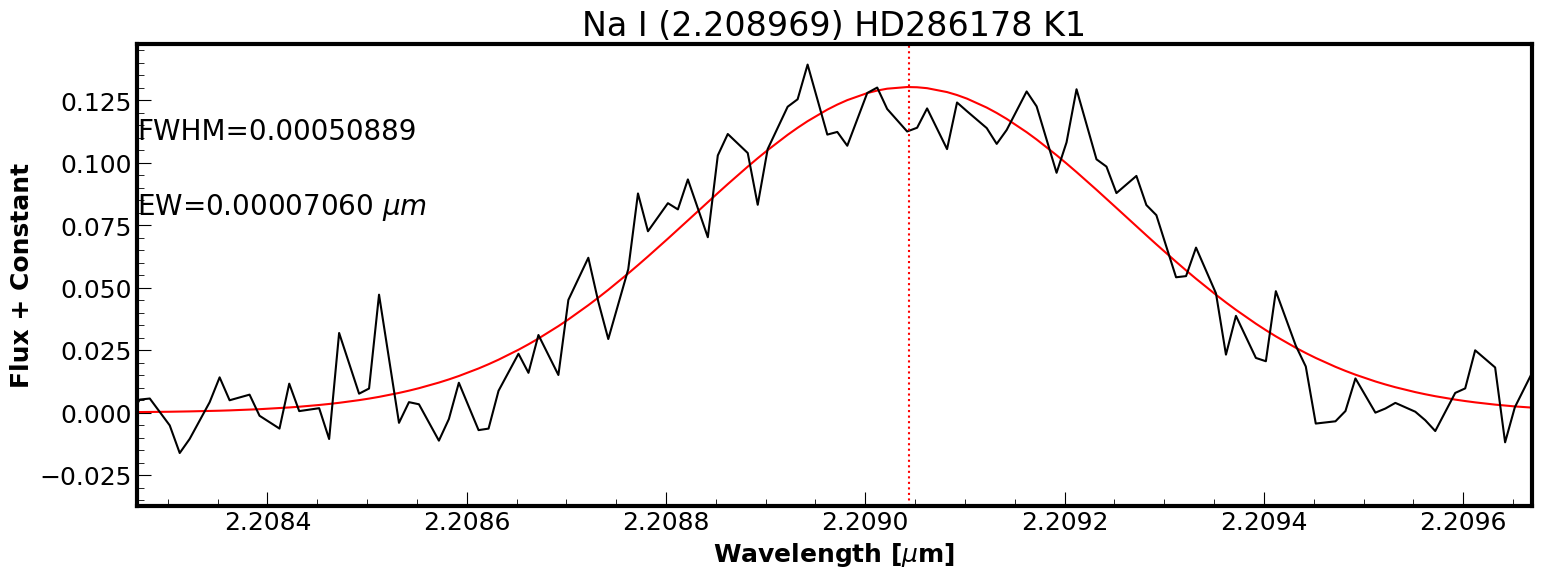

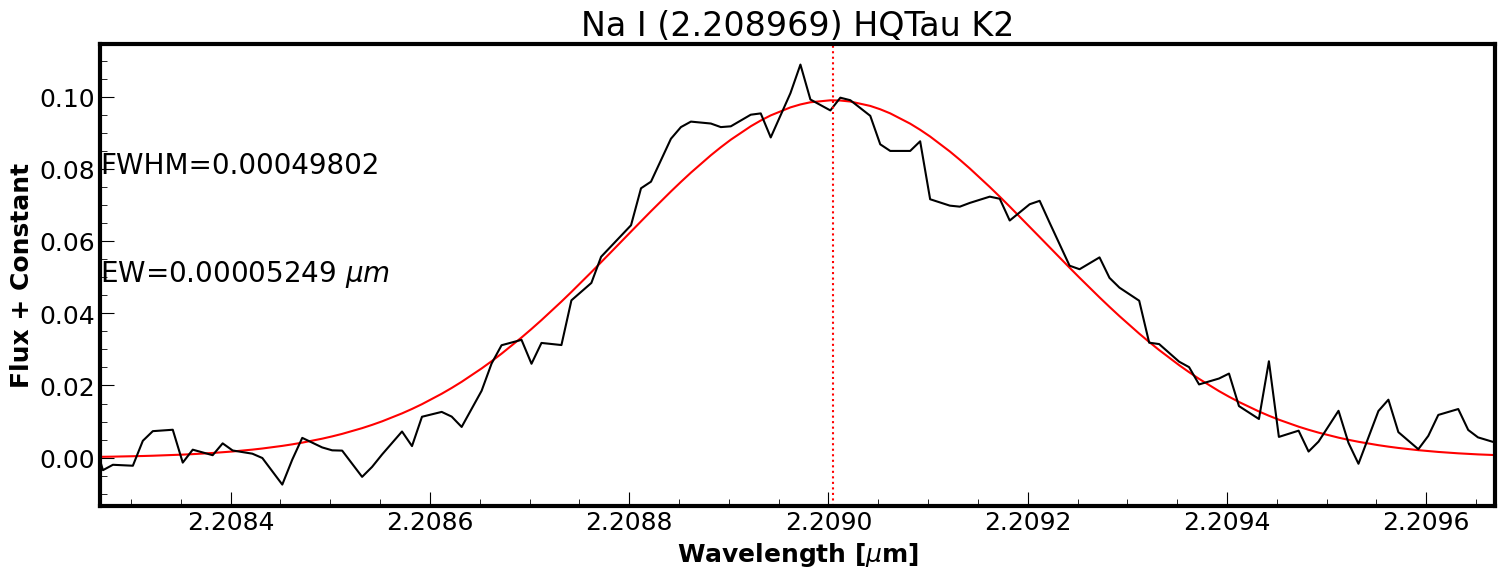

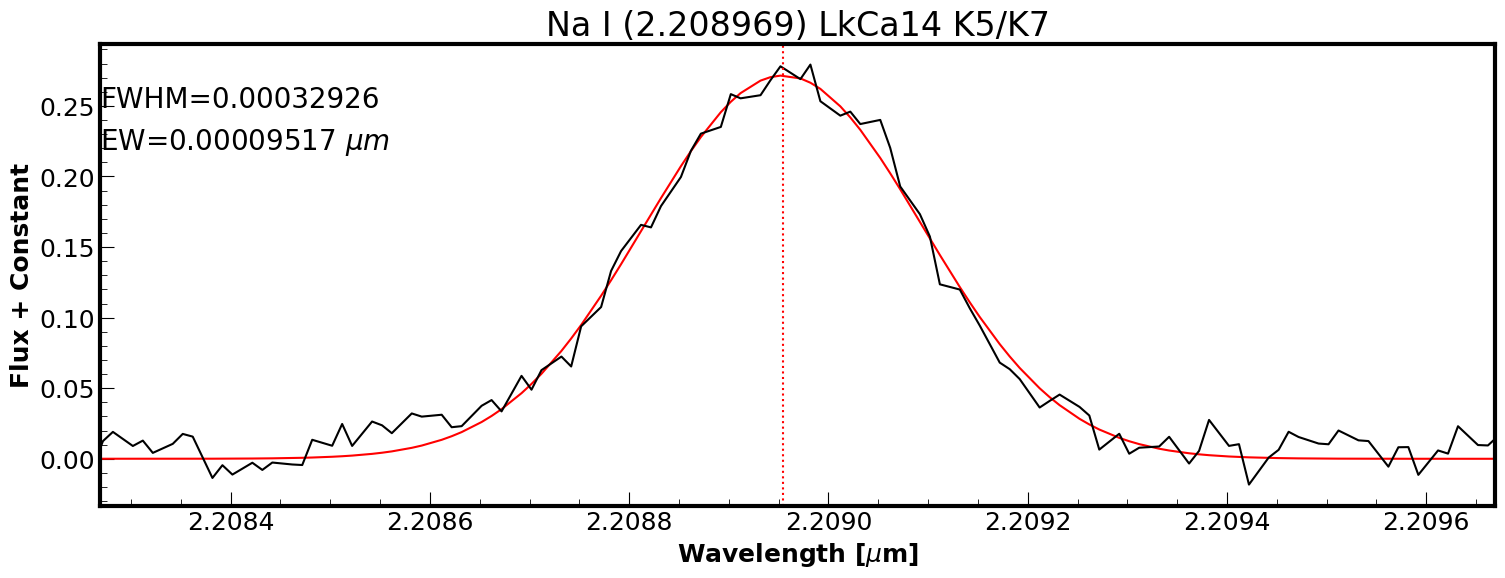

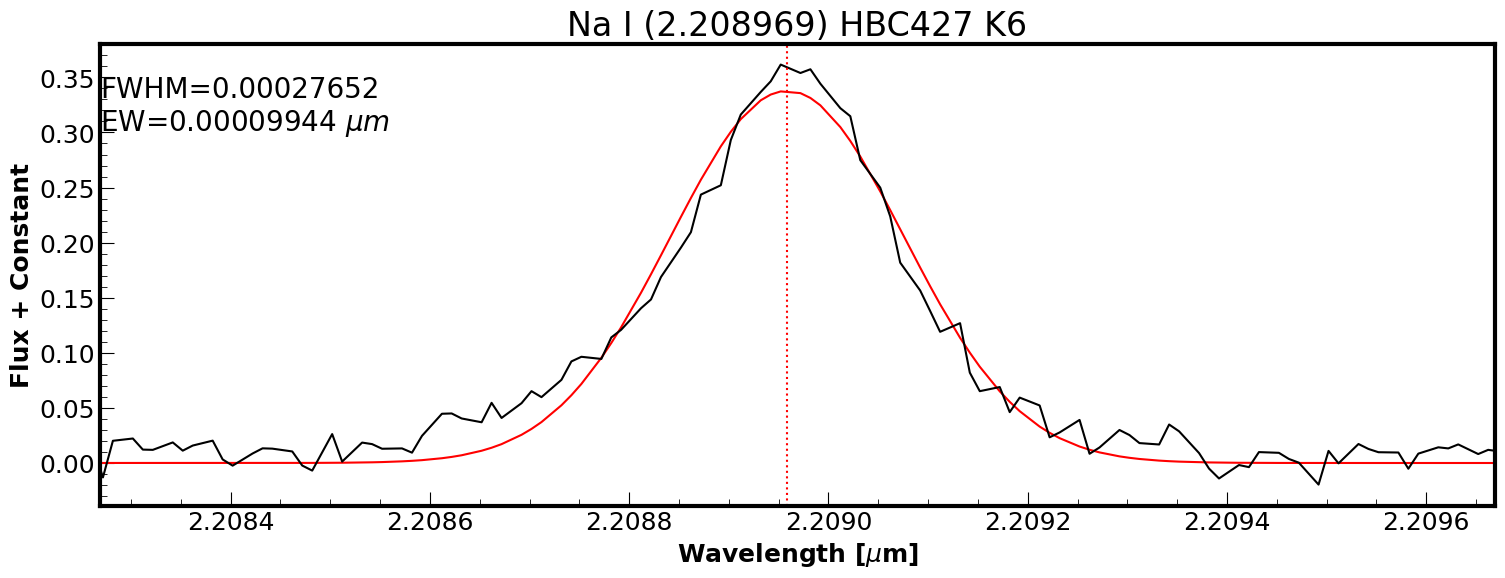

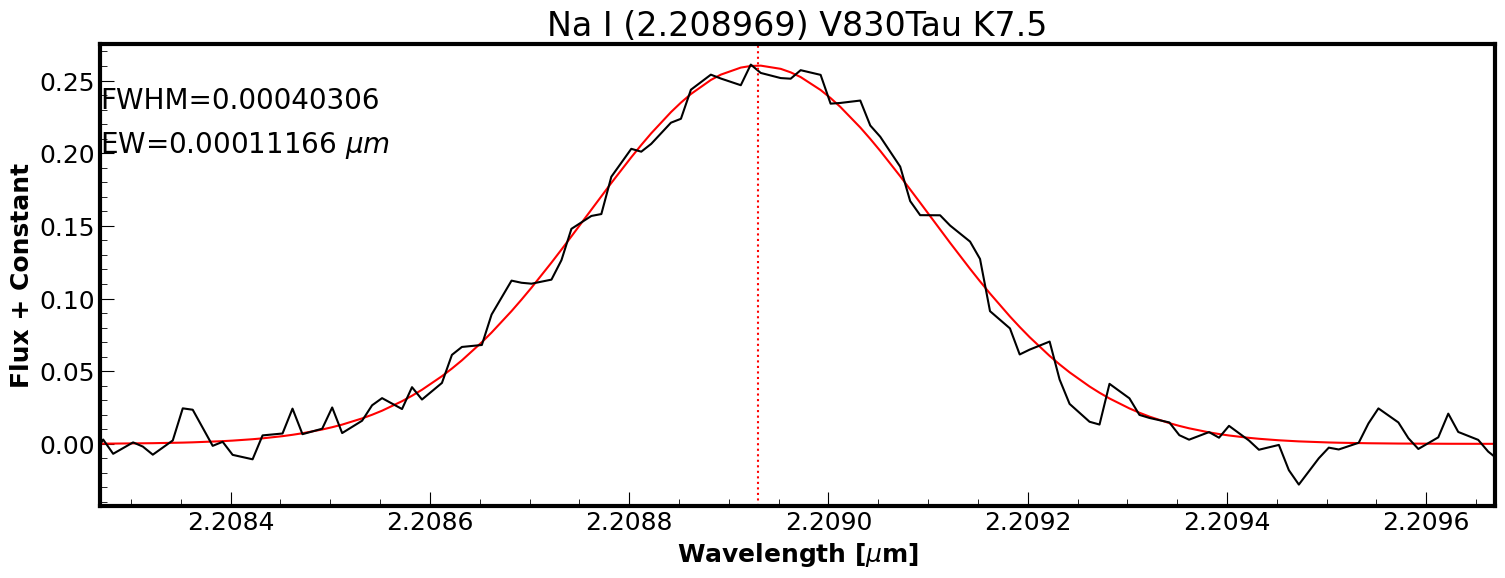

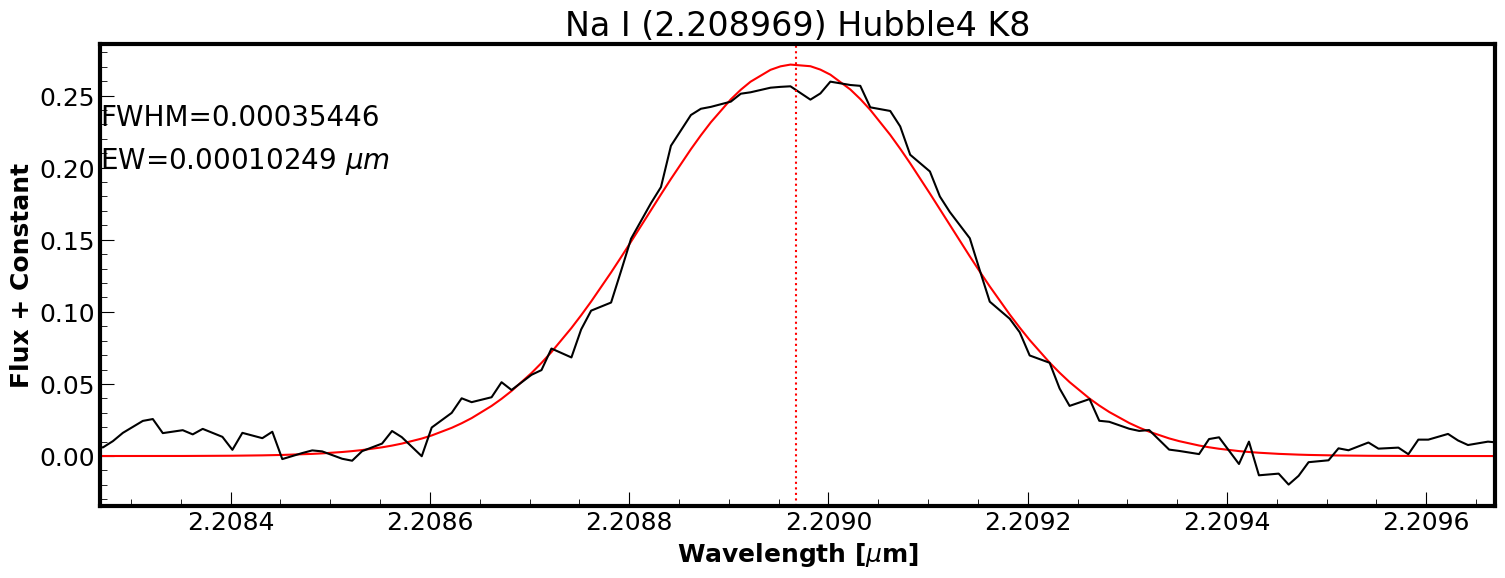

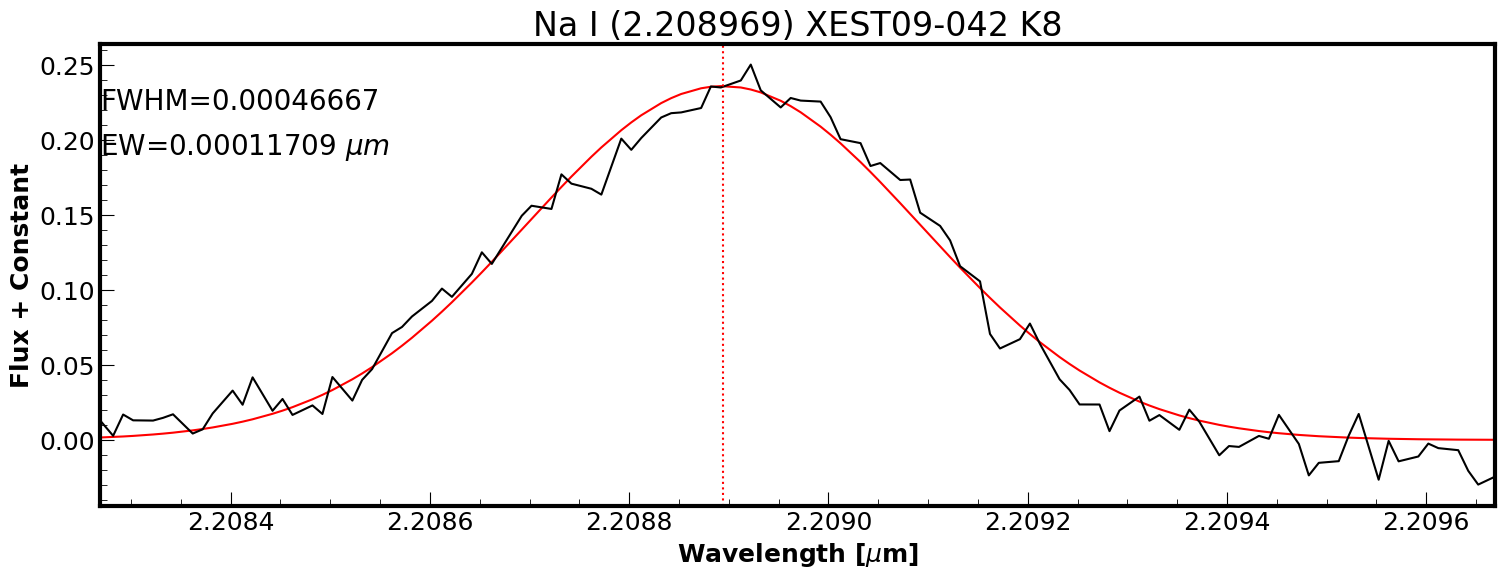

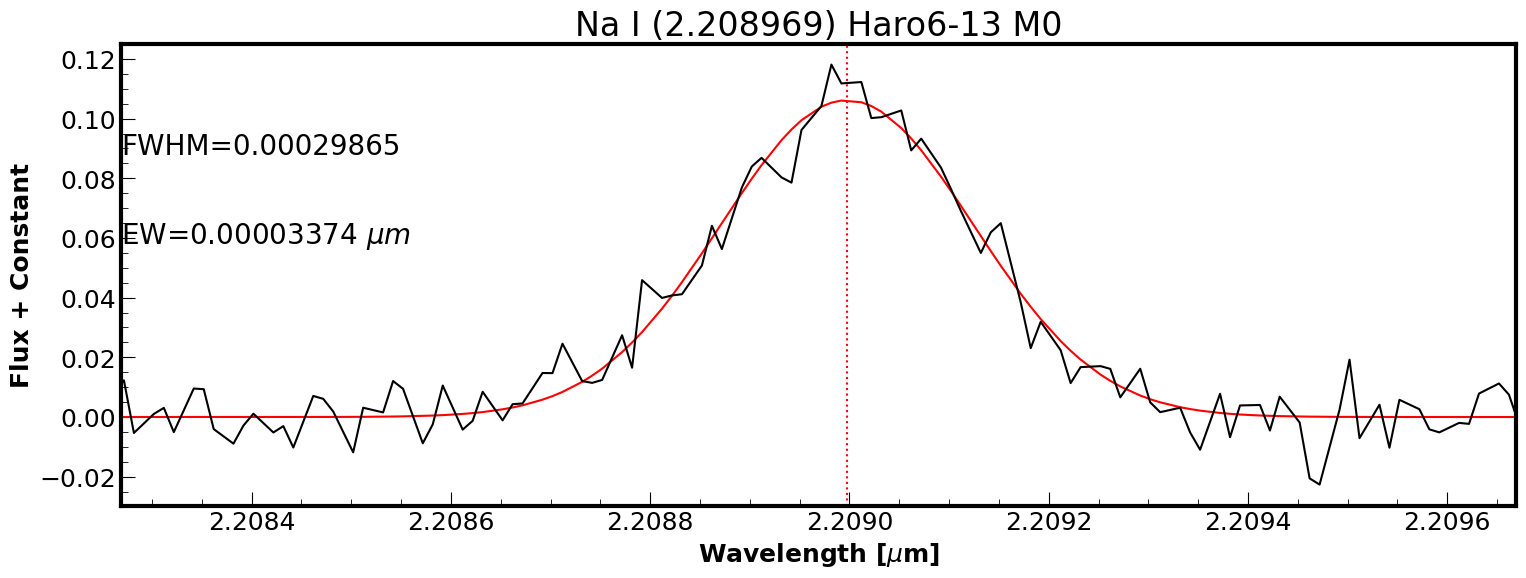

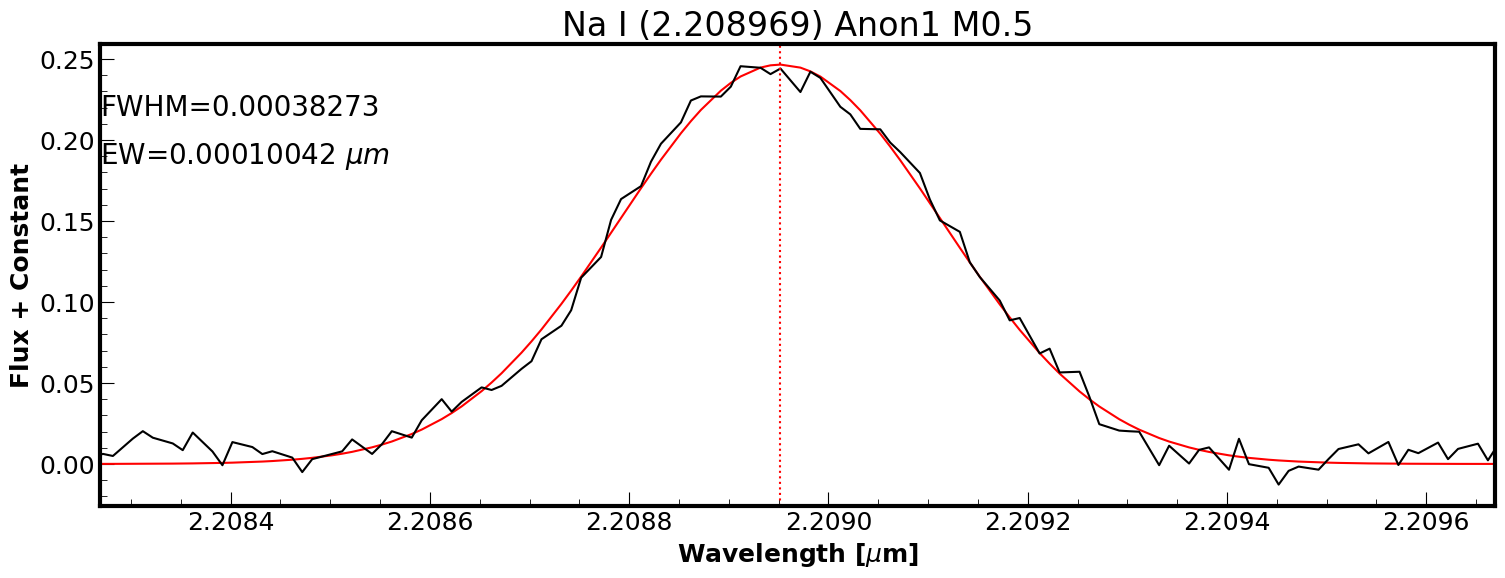

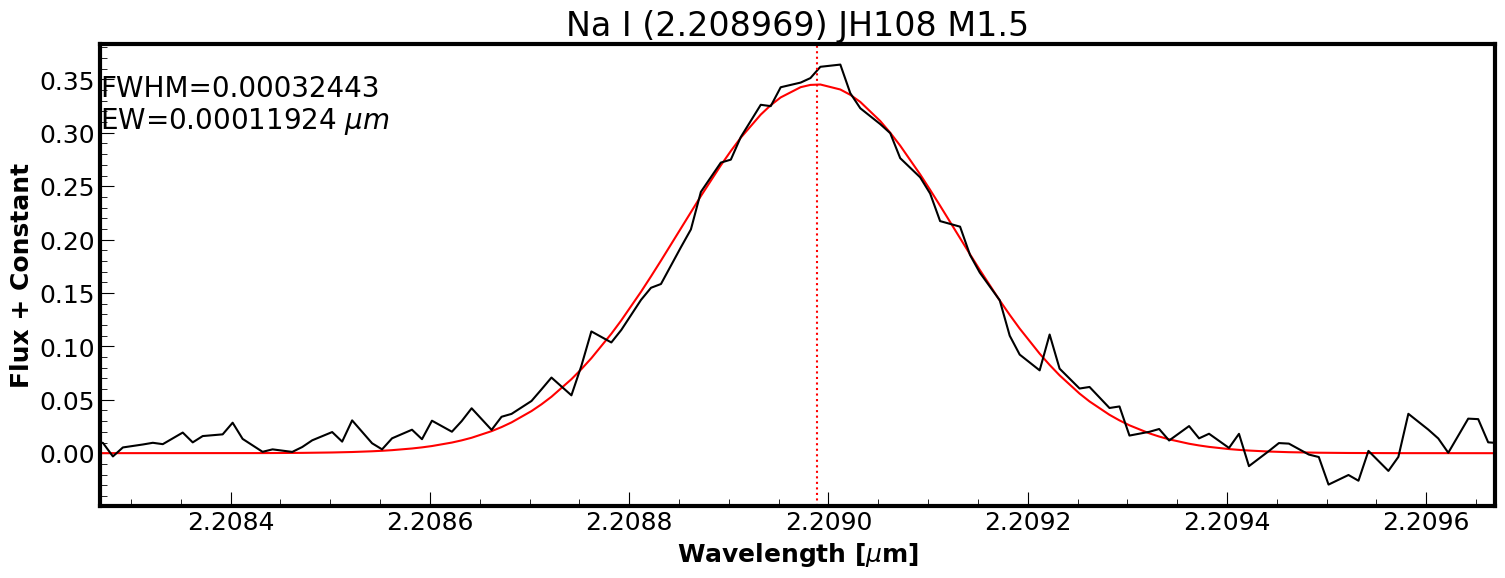

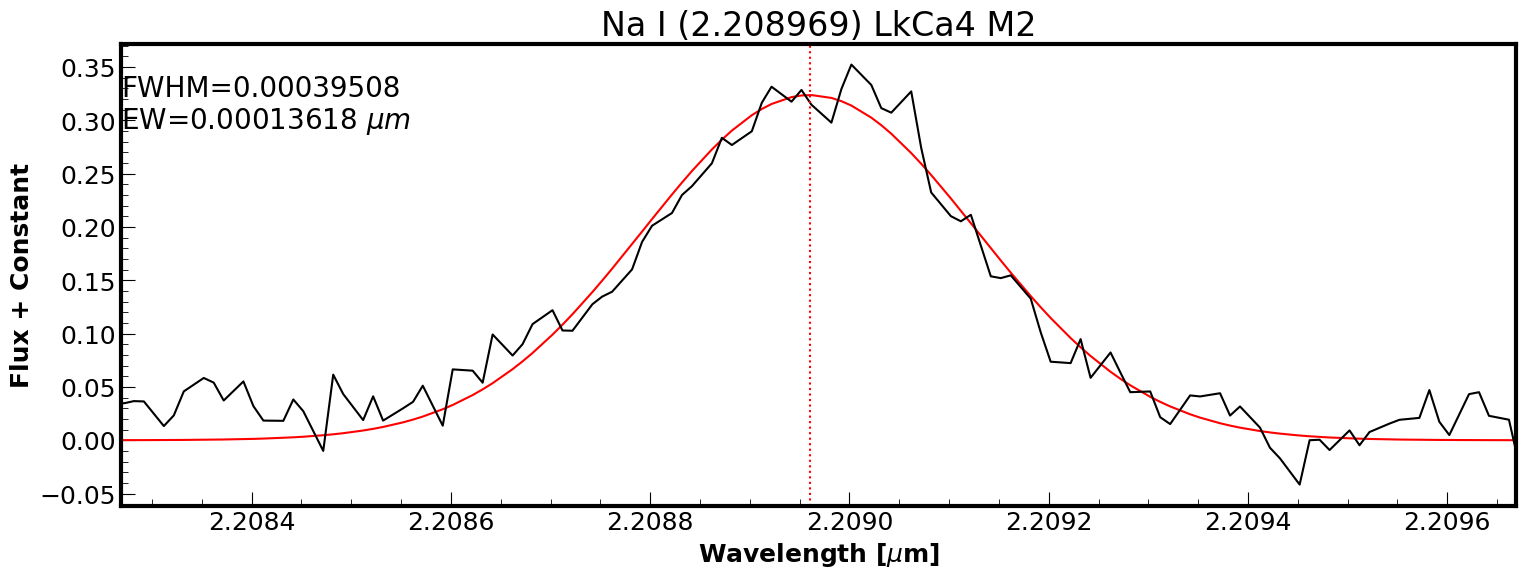

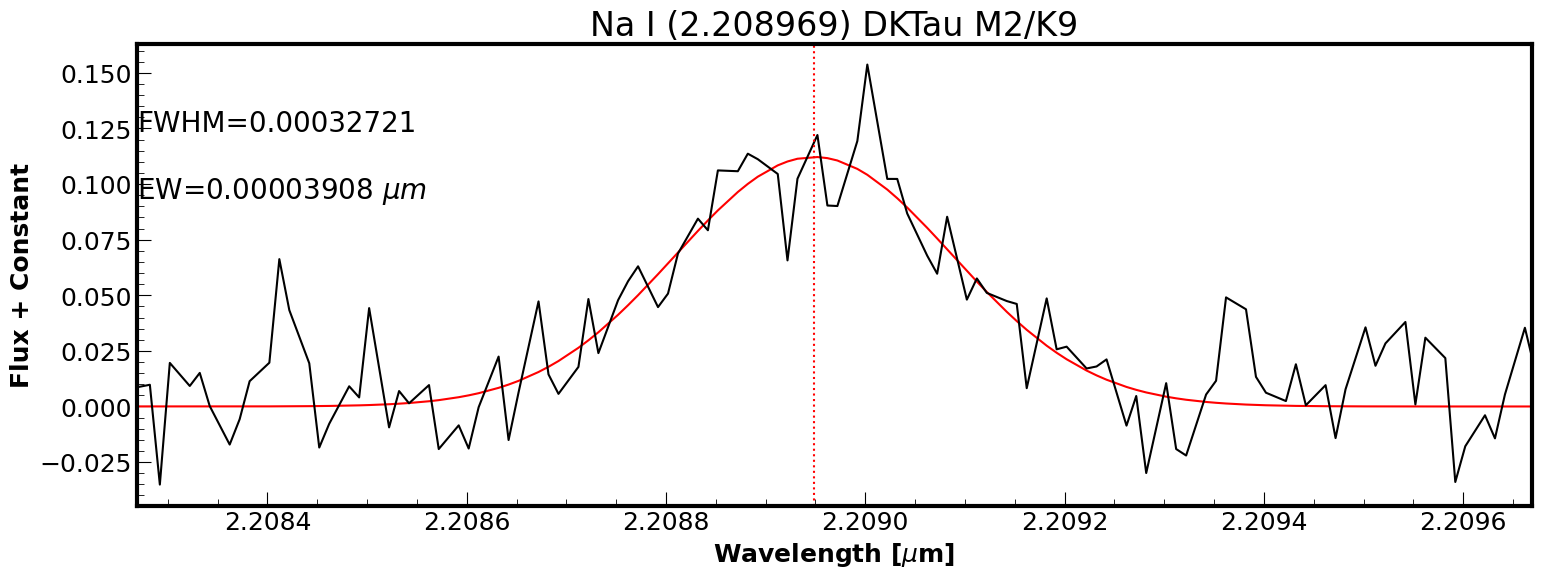

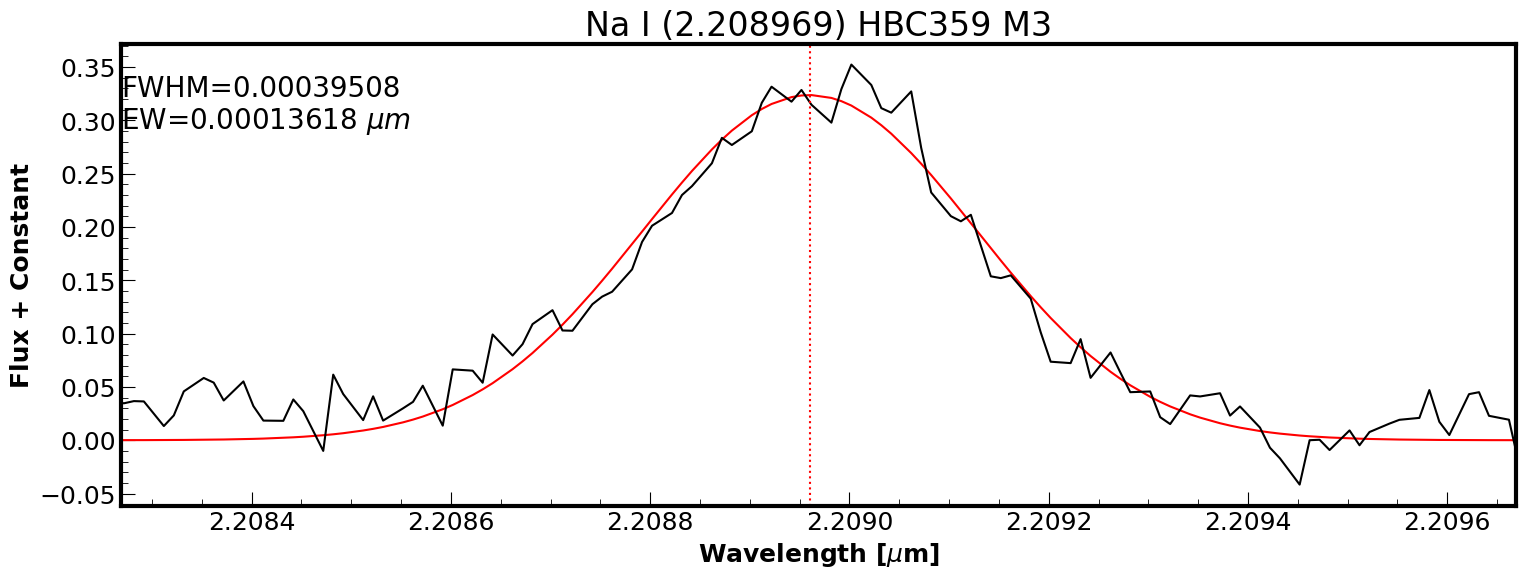

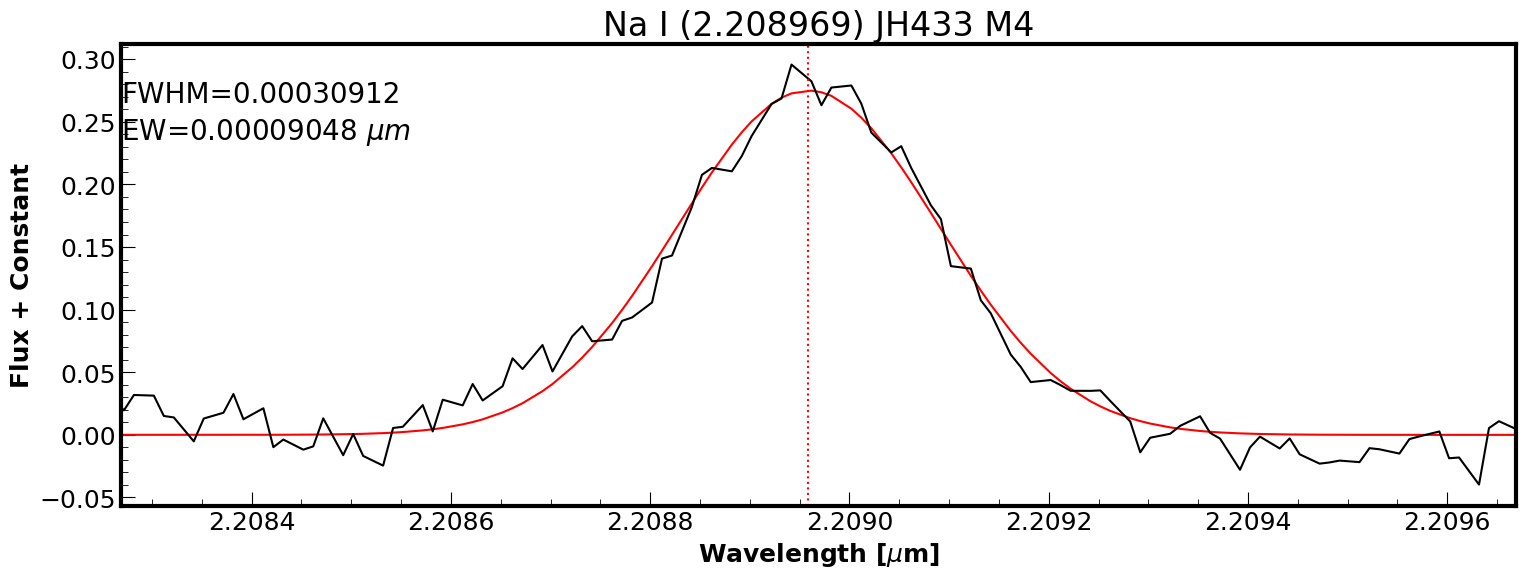

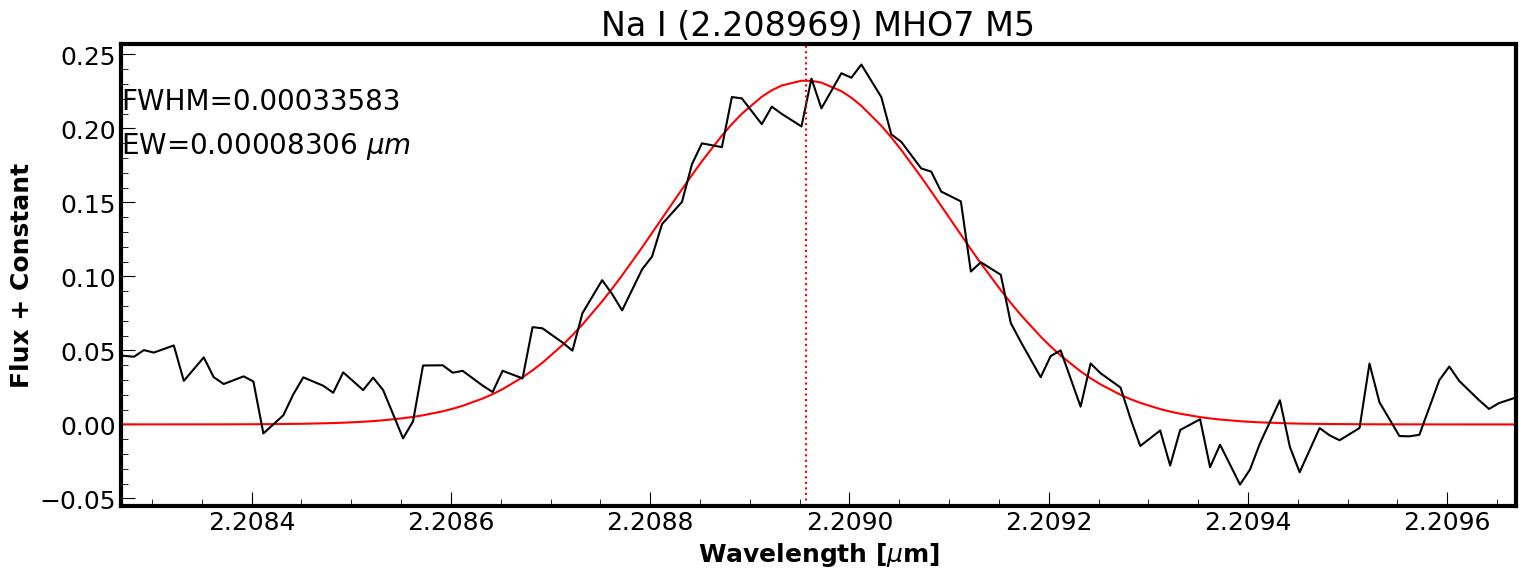

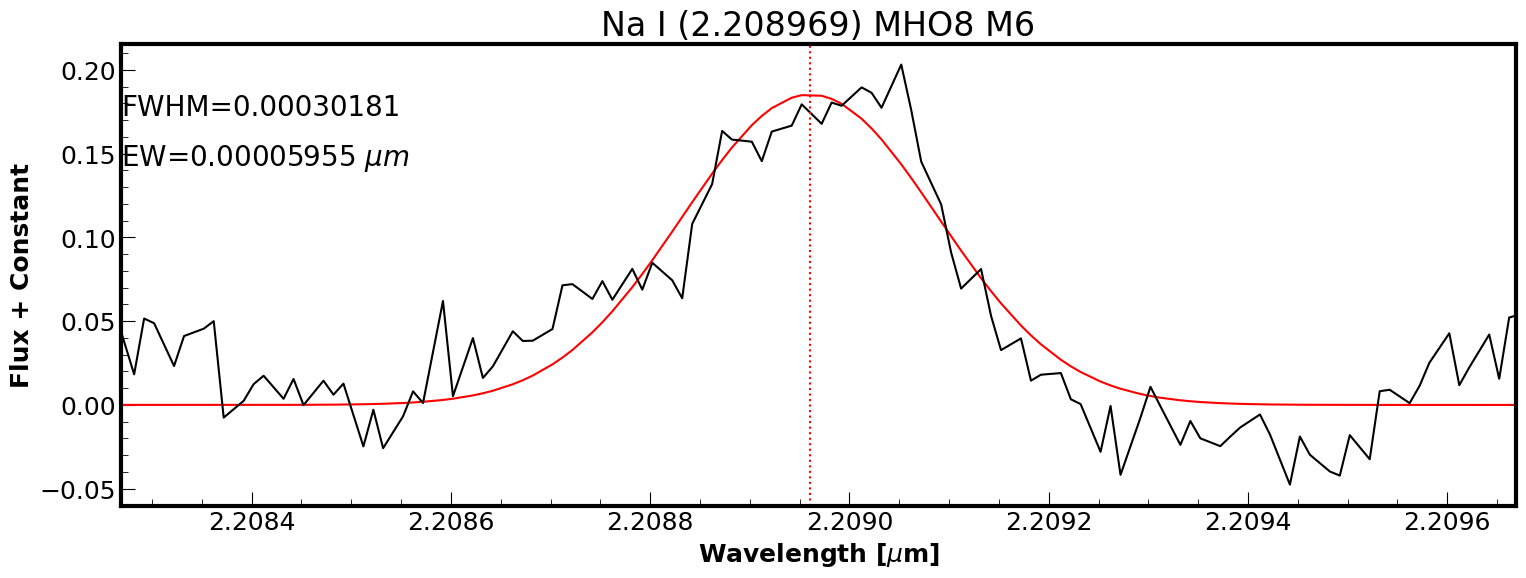

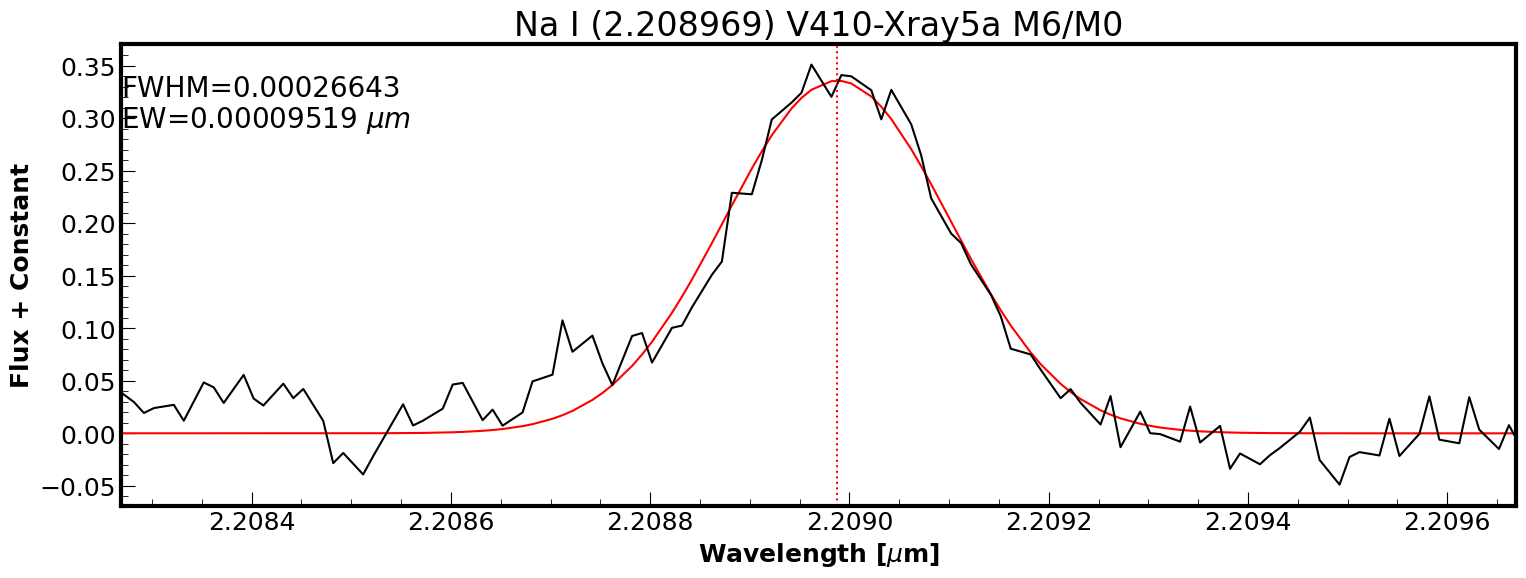

In [3]:
# Define the region for fitting
line_name = lines_table[na1_mask][0]['Spectrum'] # Species
line_center = lines_table[na1_mask][1]['Observed'] # Wavelength

idx1_stack = []
idx2_stack = []
idx3_stack = []
idx4_stack = []

normalized_flux_stack = []
continuum_stack = []

for i in range(len(standard_list)):
    continuum, idx1, idx2, idx3, idx4 = ig.local_continuum_fit(wavelen_stack[:,i],
                                                               raw_flux_stack[:,i],
                                                               1,
                                                               line_center,
                                                               spec_res,
                                                               window_size=10,
                                                               num=80)

    continuum_stack.append(continuum)

    normalized_flux_stack.append(raw_flux_stack[idx1:idx4,i]/continuum)

    idx1_stack.append(idx1)
    idx2_stack.append(idx2)
    idx3_stack.append(idx3)
    idx4_stack.append(idx4)
    # print(len(continuum))
    # fig = plt.figure(figsize=(12,6))

    # plt.plot(wavelen_stack[idx1:idx4,i],raw_flux_stack[idx1:idx4,i])
    # plt.plot(wavelen_stack[idx1:idx4,i],continuum)

    # plt.axvspan(wavelen_stack[idx1_stack[i],i],wavelen_stack[idx2_stack[i],i],alpha=0.25,color='red')
    # plt.axvspan(wavelen_stack[idx3_stack[i],i],wavelen_stack[idx4_stack[i],i],alpha=0.25,color='red')

    # plt.title(f"{standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")
    # plt.show()

min_wave = line_center - (70 * spec_res)
max_wave = line_center + (70 * spec_res)

amplitude_stack = []
center_stack = []
sigma_stack = []

pcov_stack = []

best_model_stack = []

flux_constant = np.linspace(0,-1,len(standard_list))

for i in range(len(standard_list)):
    # Define initial parameters for Gaussian fitting
    init_params = (-0.2, line_center, spec_res)#,(-0.2, lines_table[sc1_mask][1]['Observed'], 0.5)]#,0,1.0)
    
    # Perform Gaussian fitting for the current source
    popt, pcov, best_model = ig.gauss_fit(wavelen_stack[idx1_stack[i]:idx4_stack[i],i],
                                        normalized_flux_stack[i],
                                        init_params,
                                        50000)

    amplitude_stack.append(popt[0])
    center_stack.append(popt[1])
    sigma_stack.append(popt[2])

    pcov_stack.append(pcov)
    best_model_stack.append(best_model)



for i in range(len(standard_list)):
    fwhm = 2*np.sqrt(2*np.log(2))*sigma_stack[i]
    # area = np.abs(amplitude_stack[i]*sigma_stack[i]*np.sqrt(2*np.pi))
    ew = np.trapz(1-best_model_stack[i],wavelen_stack[idx1_stack[i]:idx4_stack[i],i])
    
    fig = plt.figure(figsize=(18,6))
    plt.plot(wavelen_stack[idx1_stack[i]:idx4_stack[i],i],
             1-best_model_stack[i],c='red',label='Gaussian Fit')
    
    plt.plot(wavelen_stack[idx1_stack[i]:idx4_stack[i],i],
             1-normalized_flux_stack[i],
             c='black')
    plt.axvline(center_stack[i],color='red',linestyle=':')
    # plt.axvspan(center_stack[i]-fwhm/2,center_stack[i]+fwhm/2,facecolor='red',alpha=0.2)

    # plt.ylim(top=1.05)
    plt.xlim(min_wave,max_wave)

    plt.text(min_wave,np.nanmax(1-normalized_flux_stack[i])-0.03,f'FWHM={fwhm:.8f}')
    # plt.text(2.208,np.nanmax(1-normalized_flux_stack[i])-0.03,fr'Area={area:.8f}')
    plt.text(min_wave,np.nanmax(1-normalized_flux_stack[i])-0.06,fr'EW={ew:.8f} $\mu m$')
    
    plt.title(f"{line_name} ({line_center}) {standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")

    plt.ylabel('Flux + Constant')
    plt.xlabel(r'Wavelength [$\mu$m]')
    plt.show()

In [4]:
area_stack = []
for i in range(len(standard_list)):
    gauss_area = -1*amplitude_stack[i]*np.sqrt(2*np.pi*sigma_stack[i]**2)
    area_stack.append(gauss_area)
    # print(gauss_area) # allegedly the formula for area of a Gaussian

Mess with area calculation and also errors on the area (equivalent width)

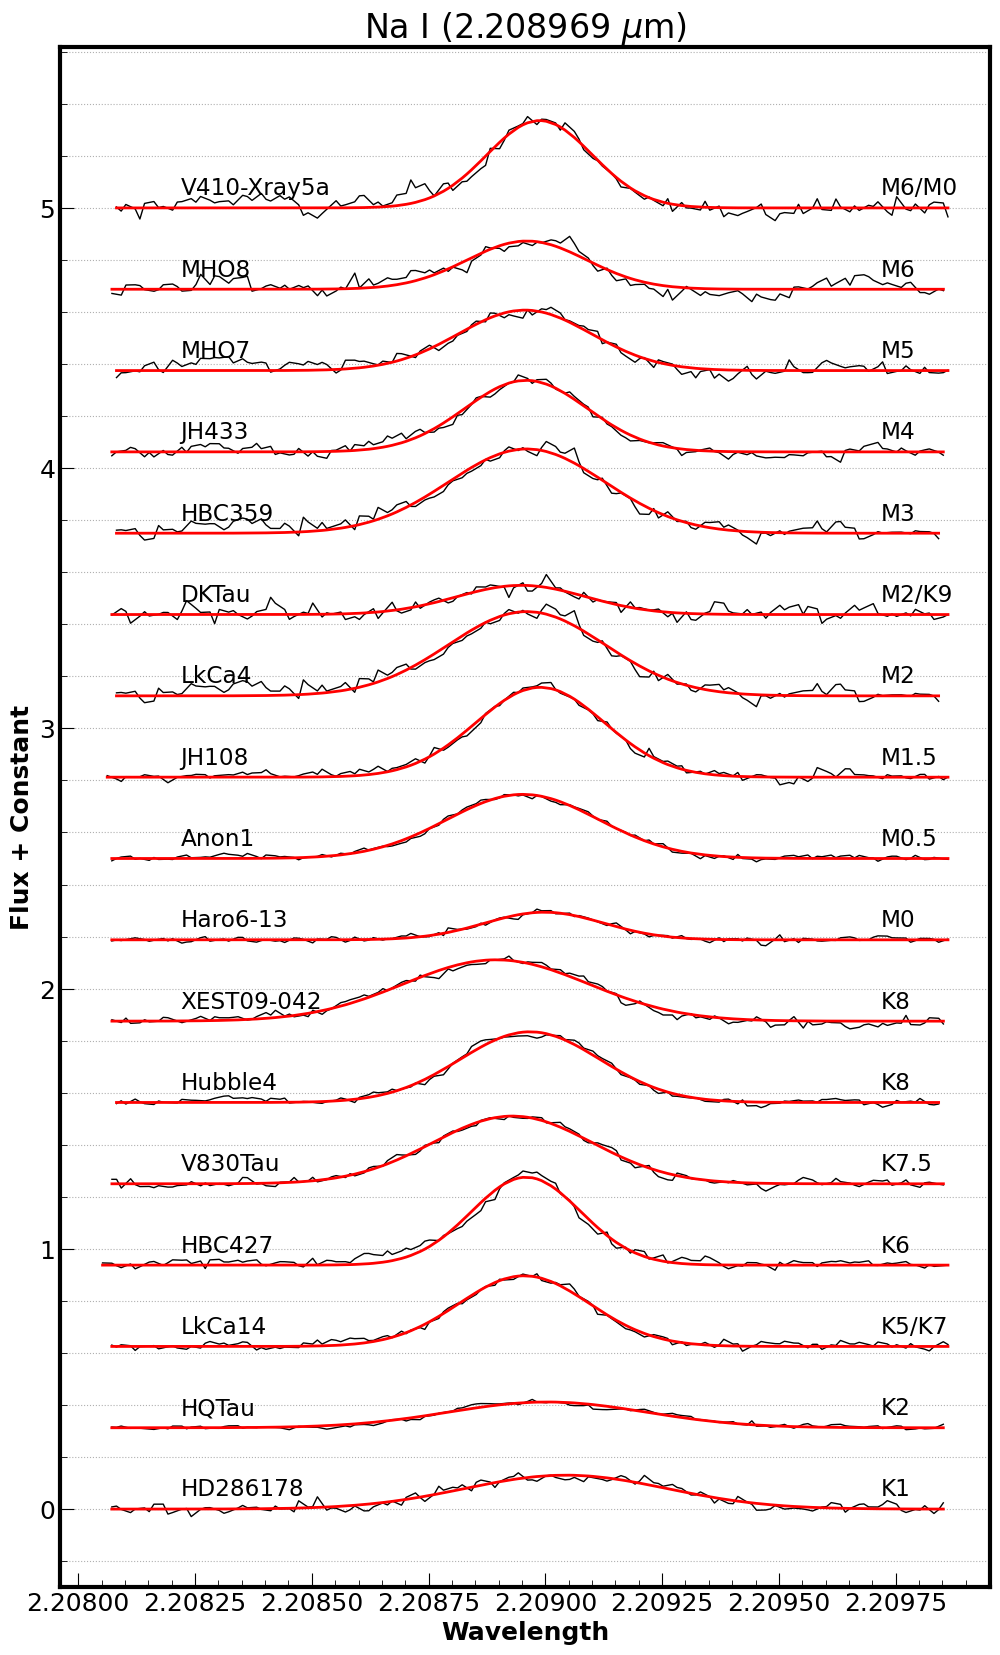

In [5]:
# Define the region for fitting
# line_center = lines_table[na1_mask]['Observed'][1]
min_wave = line_center - (75 * spec_res)
max_wave = line_center + (75 * spec_res)

flux_constant = np.linspace(0,5,len(standard_list))

fig = plt.figure(figsize=(12,20))
for i in range(len(standard_list)):
    # Plot the normalized flux
    plt.plot(wavelen_stack[idx1_stack[i]:idx4_stack[i],i],
             (1-normalized_flux_stack[i])+flux_constant[i],
             c='black',lw=1)
    
    # Plot the gaussian fit to the flux
    plt.plot(wavelen_stack[idx1_stack[i]:idx4_stack[i],i],
             (1-best_model_stack[i])+flux_constant[i],
             c='red',lw=2)
    
    # Source Name Label
    plt.text(min_wave,0.05+flux_constant[i],
            s=f"{standard_table['Name'][i]}",
            fontsize='small')
    
    # Source Spectral Type Label
    plt.text(max_wave,0.05+flux_constant[i],
             s=f"{standard_table['Spectral_Type'][i]}",
             fontsize='small')

    plt.title(f"{line_name} ({line_center} $\mu$m)")
    plt.ylabel('Flux + Constant')
    plt.xlabel('Wavelength')
plt.grid(which='both',axis='y',ls=':')
plt.show()

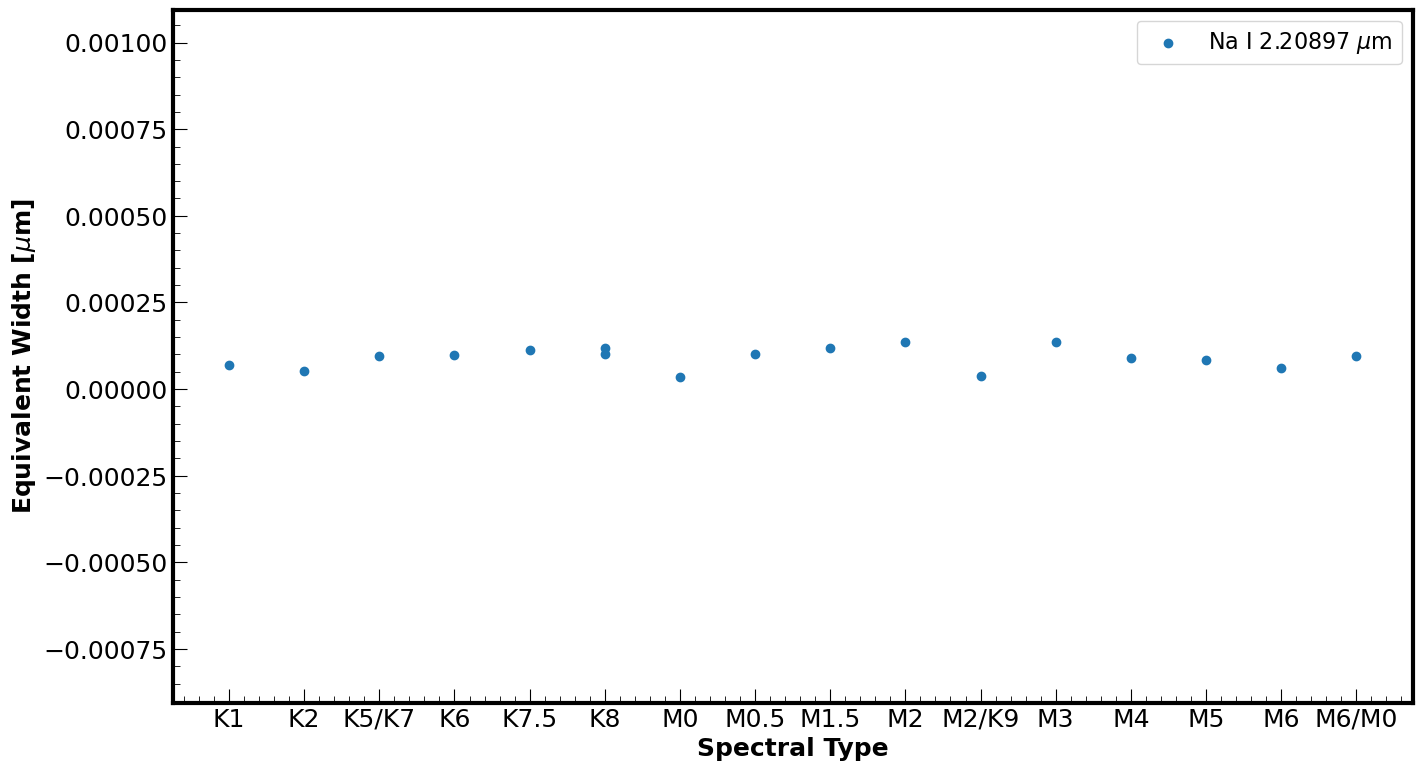

In [6]:
ew_stack = [] # empty list to load in equivalent widths
for i in range(len(standard_list)):
    ew = np.trapz(1-best_model_stack[i],wavelen_stack[idx1_stack[i]:idx4_stack[i],i]) # integrate the gaussian
    ew_stack.append(ew)
standard_table['ew_na1_2_2089'] = ew_stack

fig = plt.figure(figsize=(16,9))

plt.scatter(standard_table['Spectral_Type'], standard_table['ew_na1_2_2089'], label=f"{line_name} {line_center:.5f} $\mu$m")
# plt.scatter(standard_table['Spectral_Type'], area_stack)
plt.ylim(np.nanmedian(ew_stack)+-0.001,np.nanmedian(ew_stack)+0.001)

# plt.ylim(np.nanmedian(area_stack)-0.001,np.nanmedian(area_stack)+0.001)

plt.xlabel('Spectral Type')
plt.ylabel(r'Equivalent Width [$\mu$m]')
# plt.title(f"{line_name} {line_center} $\mu$m")

plt.legend()
plt.show()

In [7]:
standard_table = standard_table.iloc[:,1:]
standard_table.to_csv('./standard_table_v2.txt')

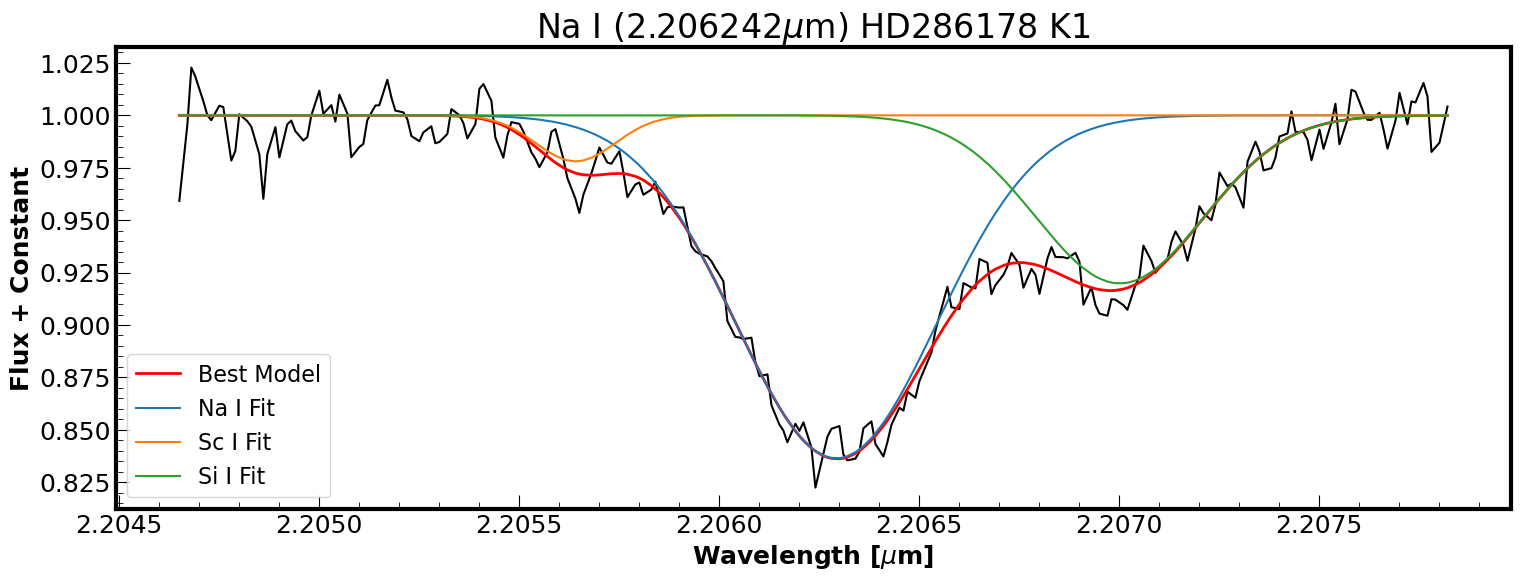

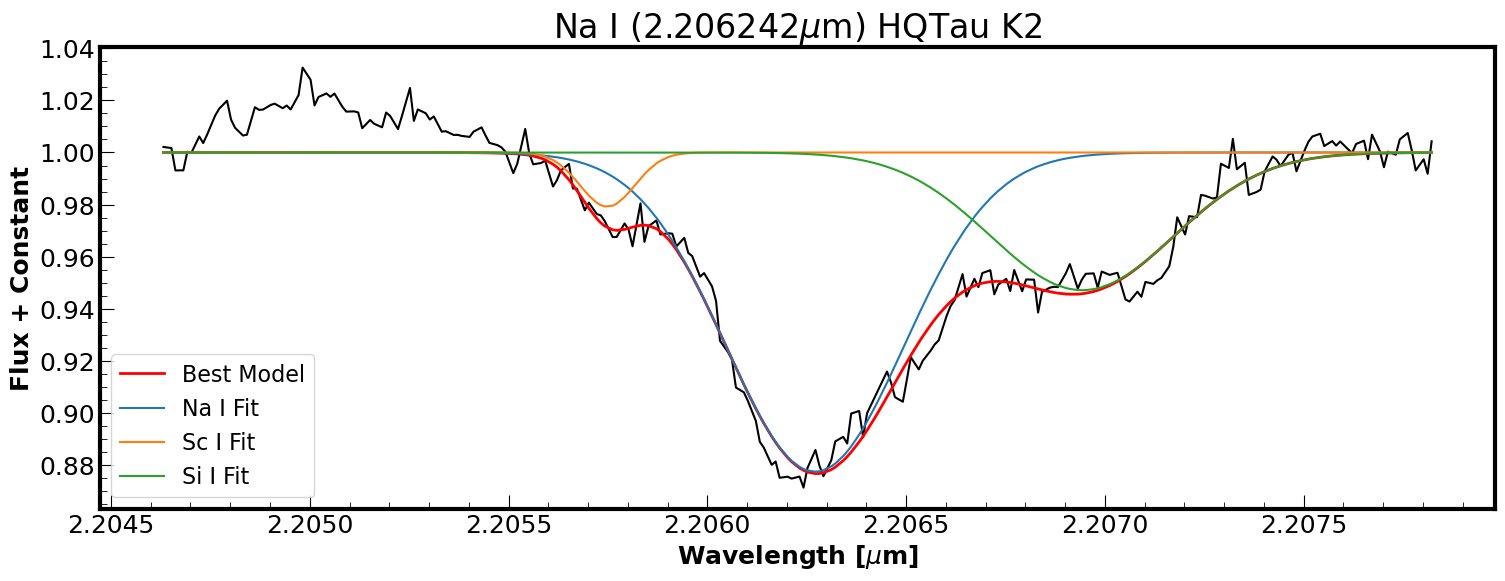

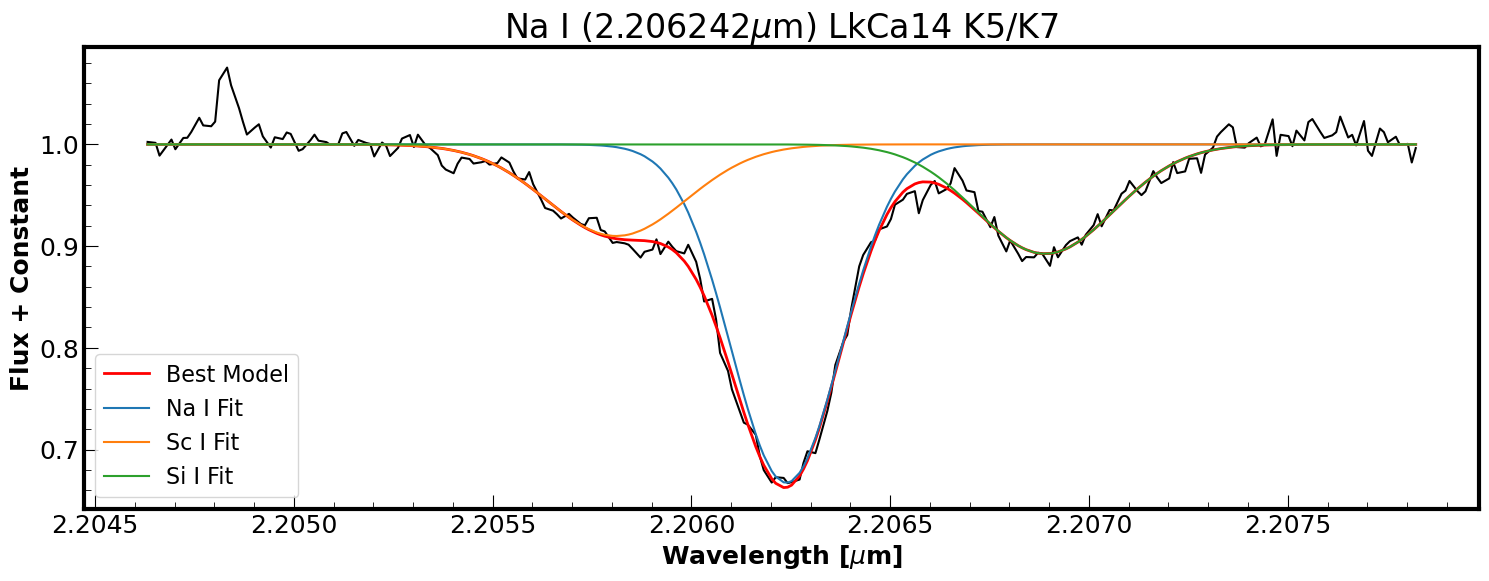

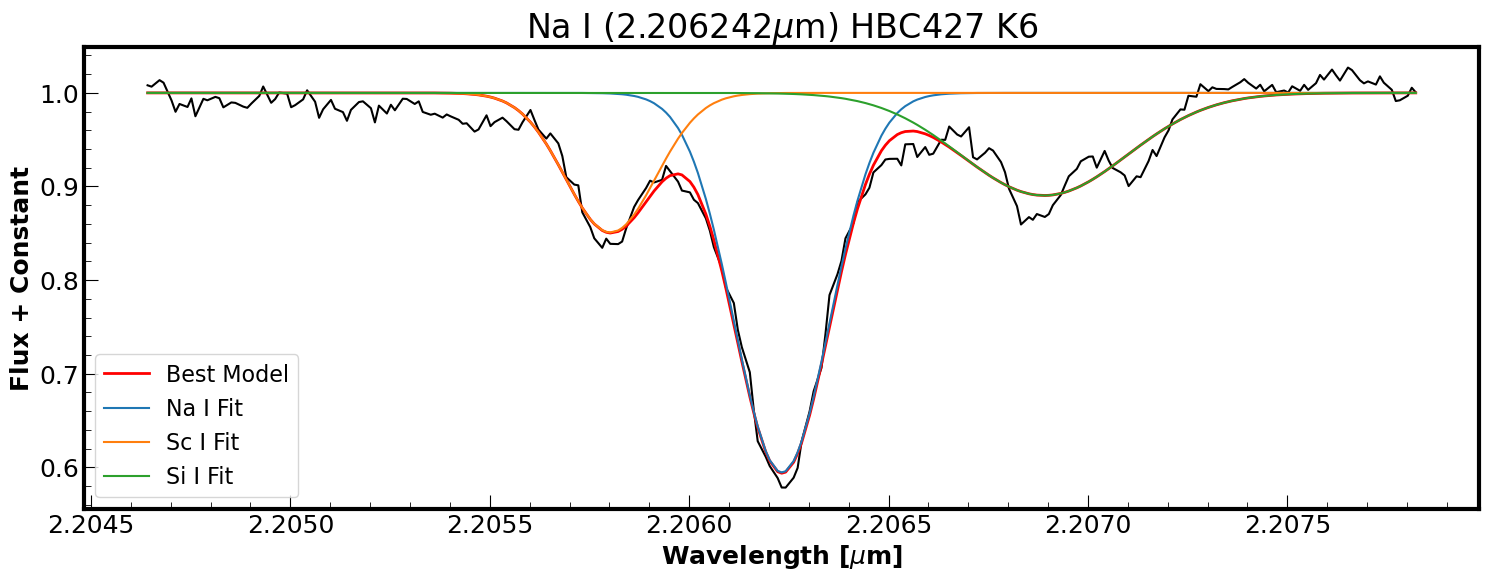

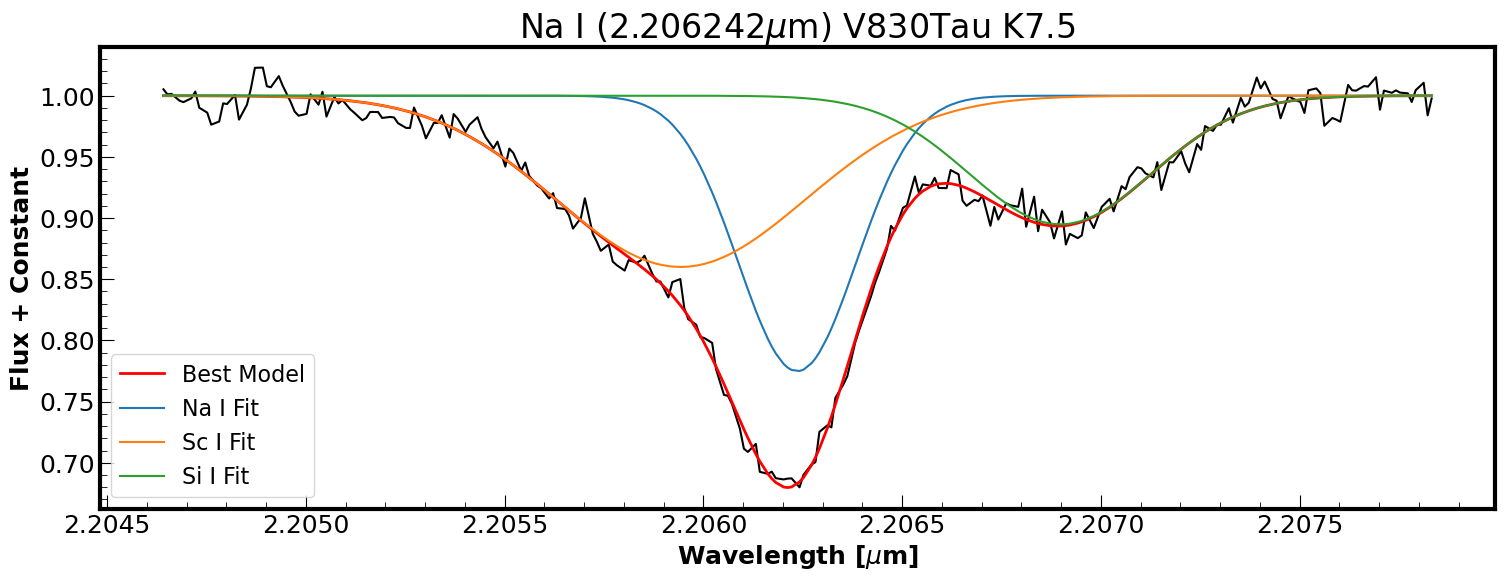

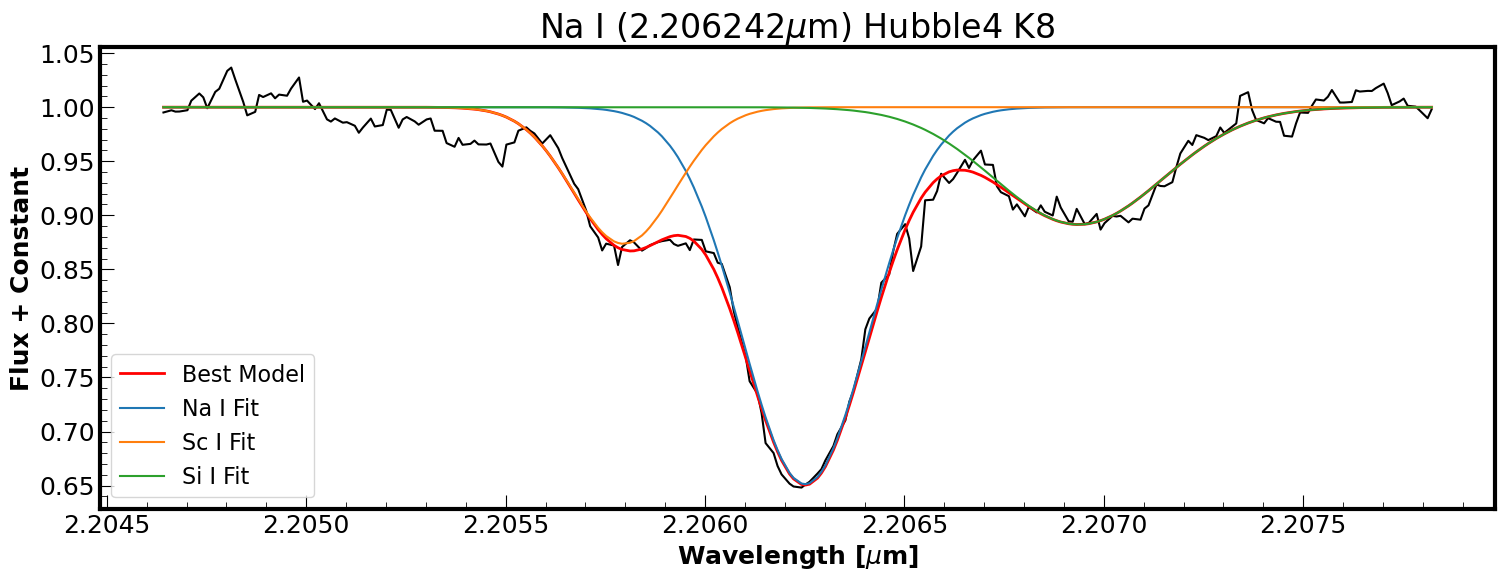

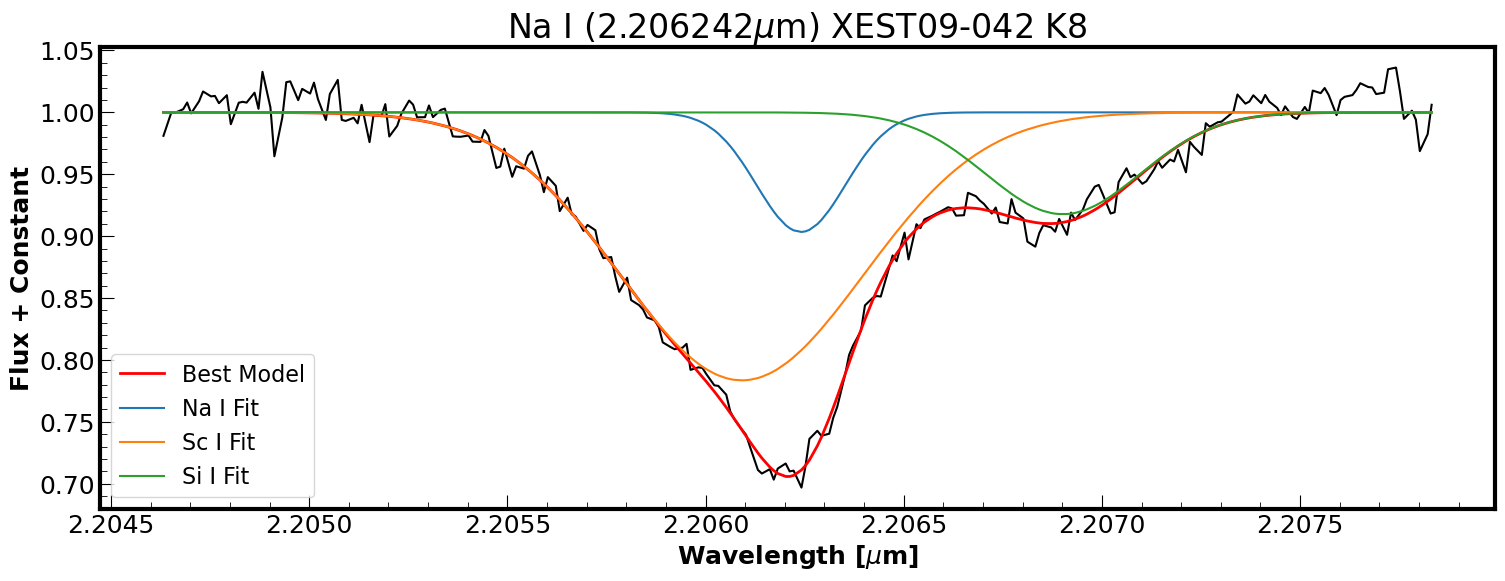

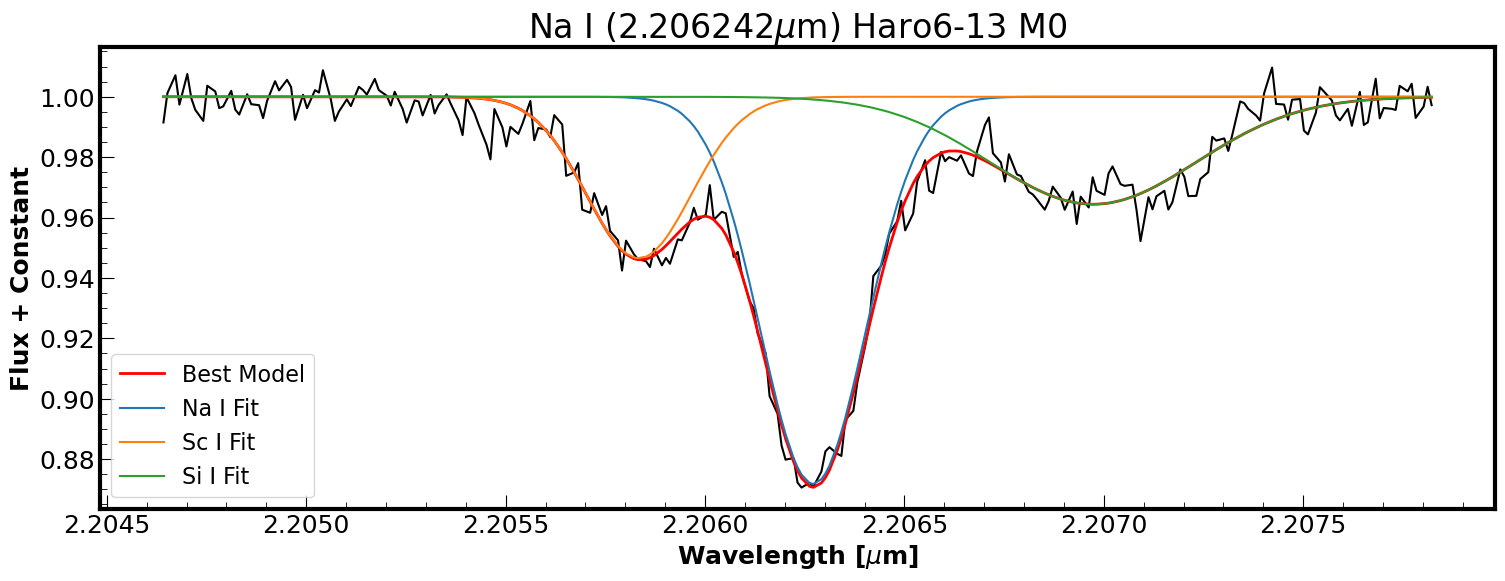

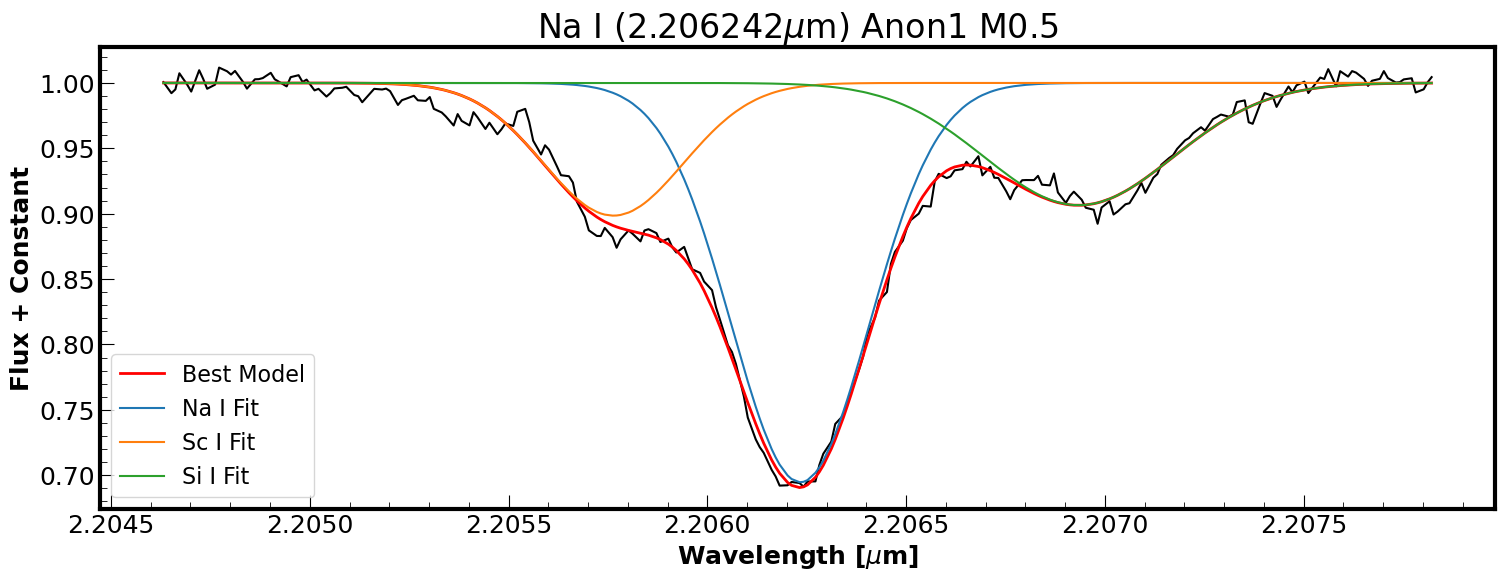

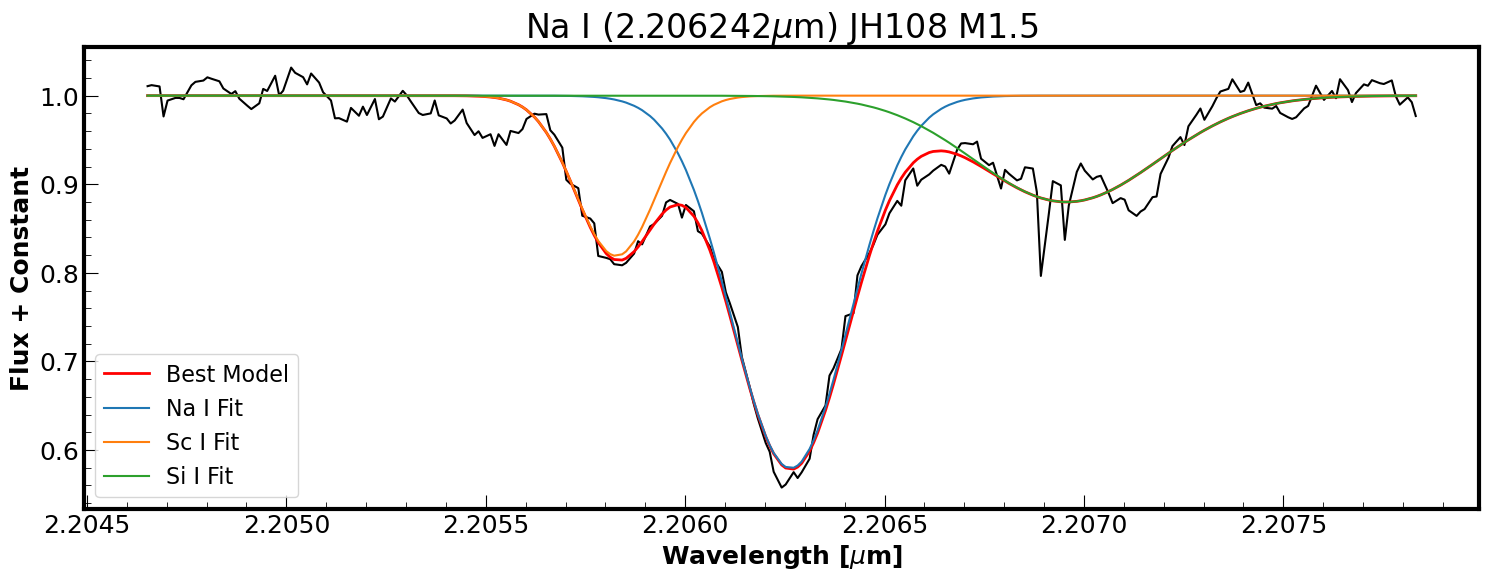

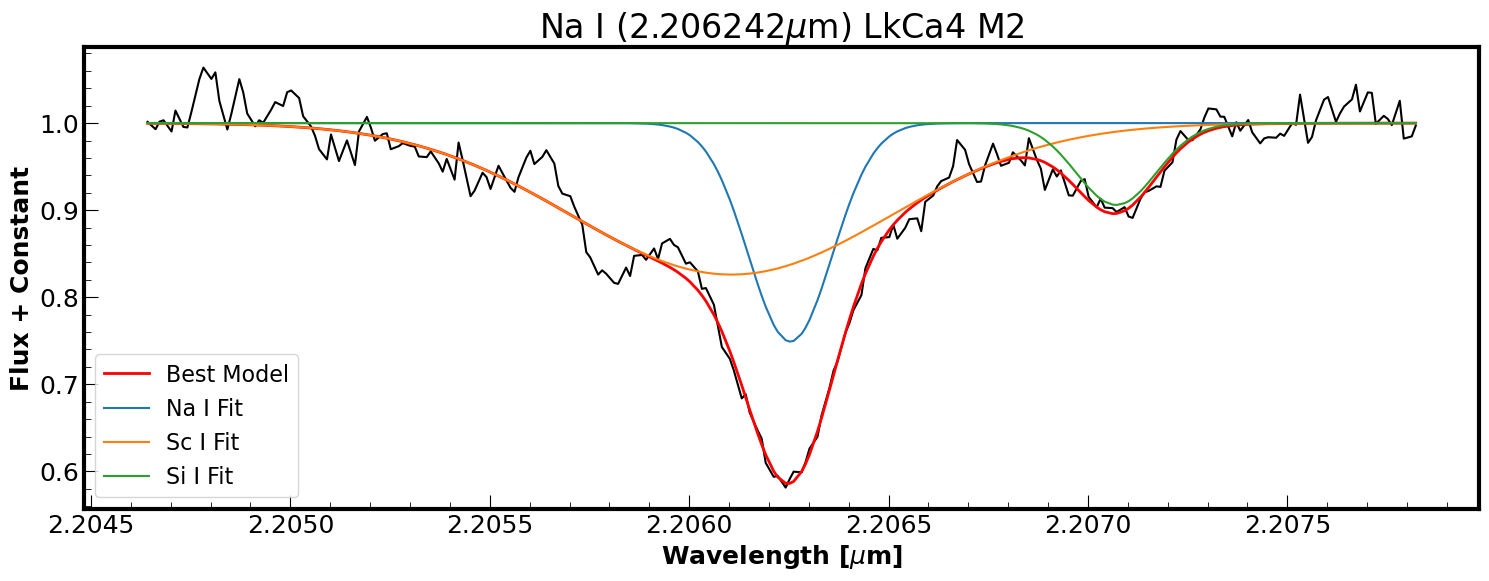

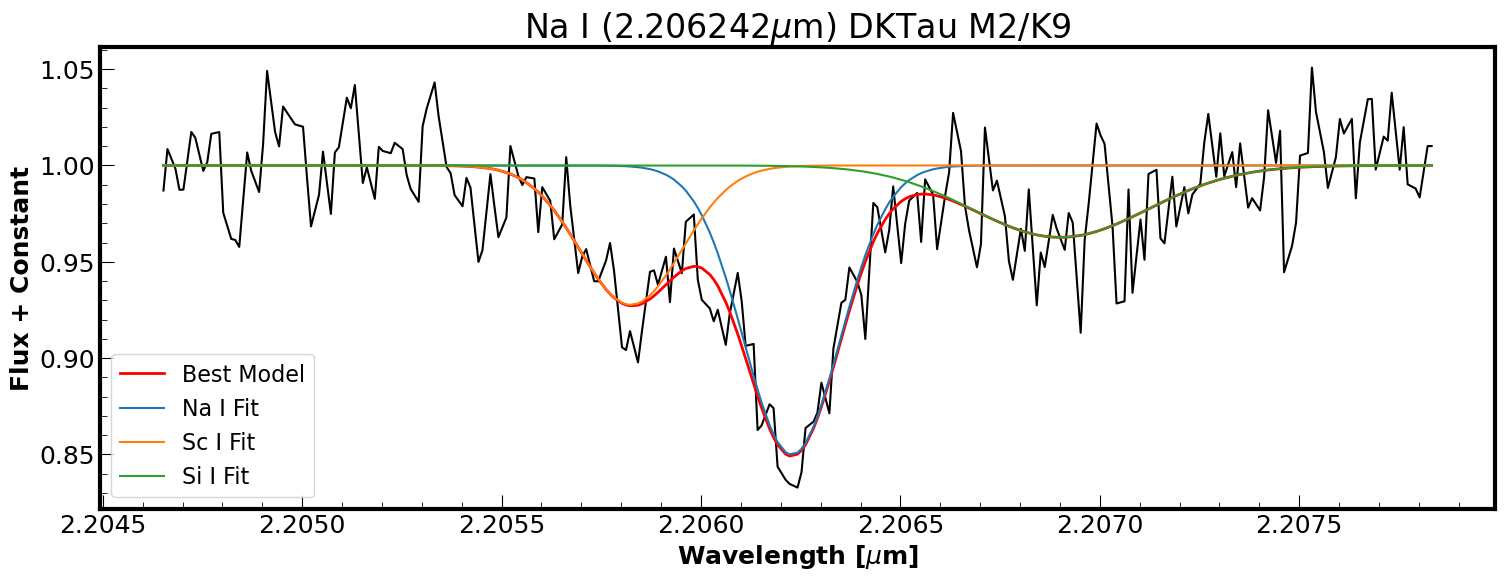

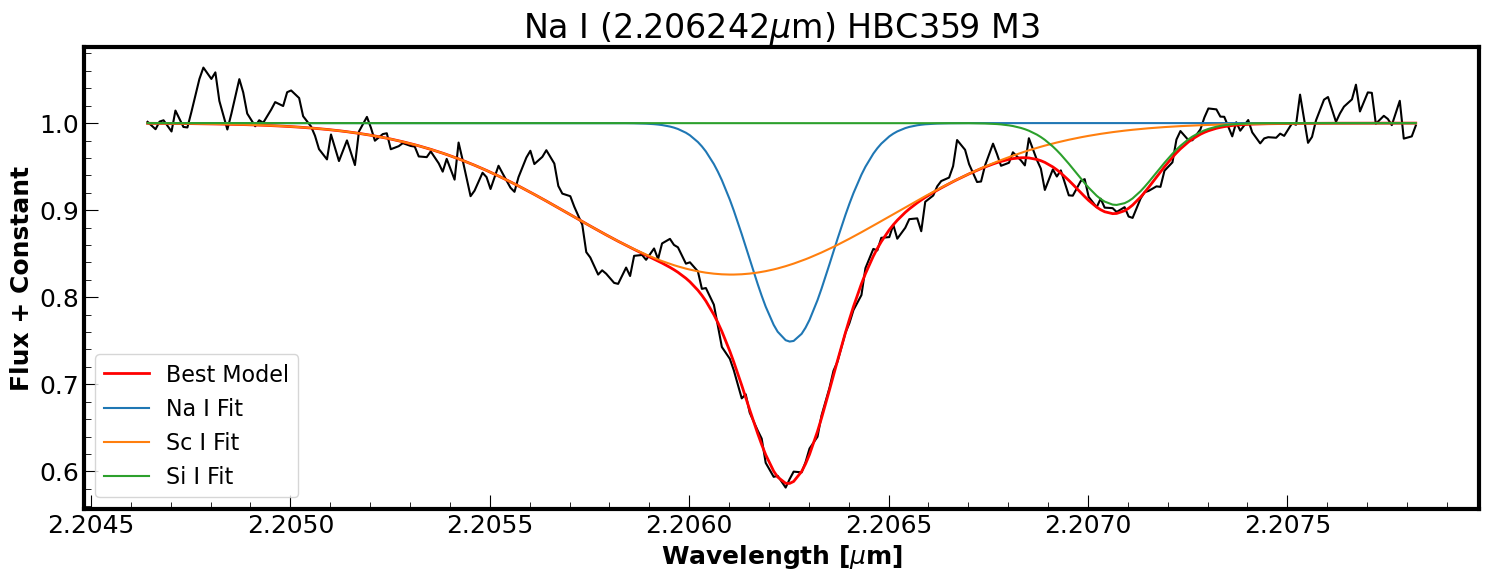

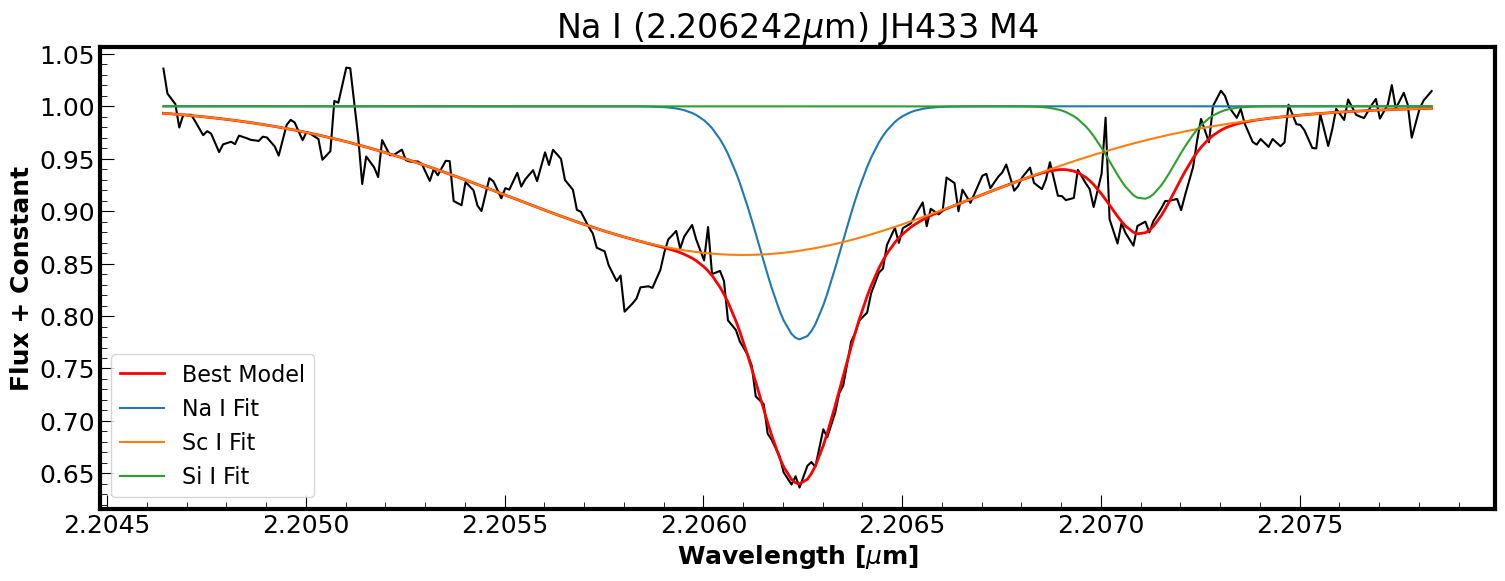

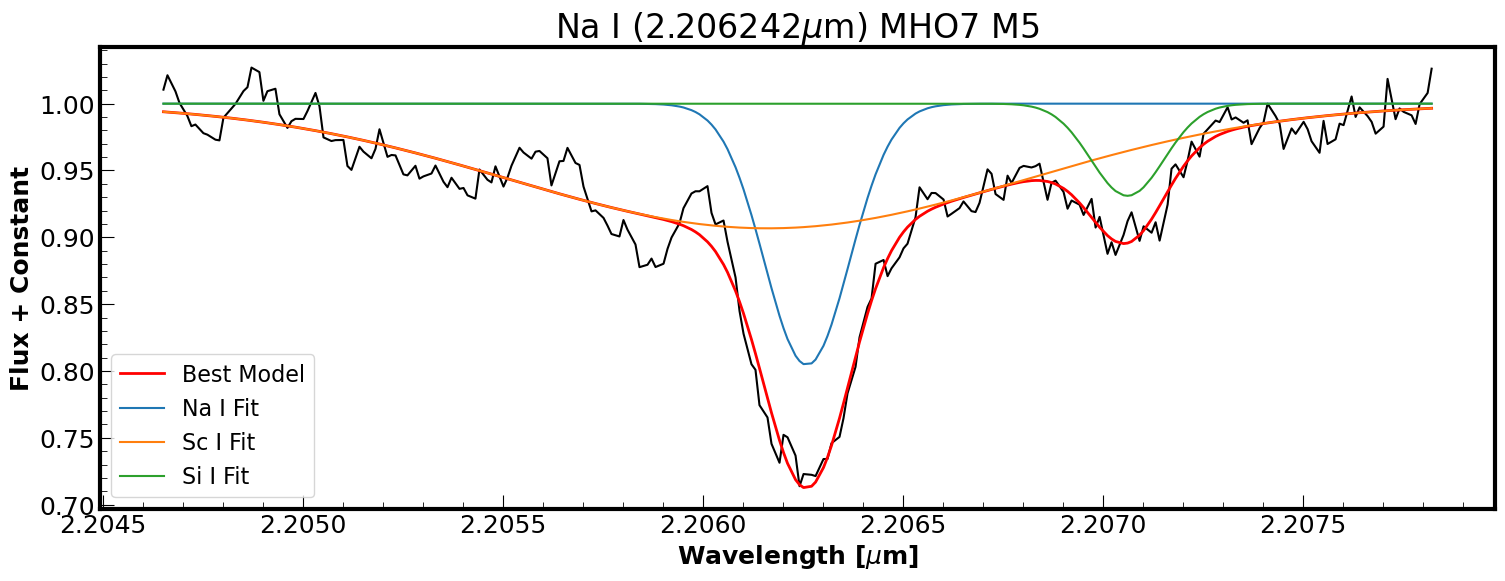

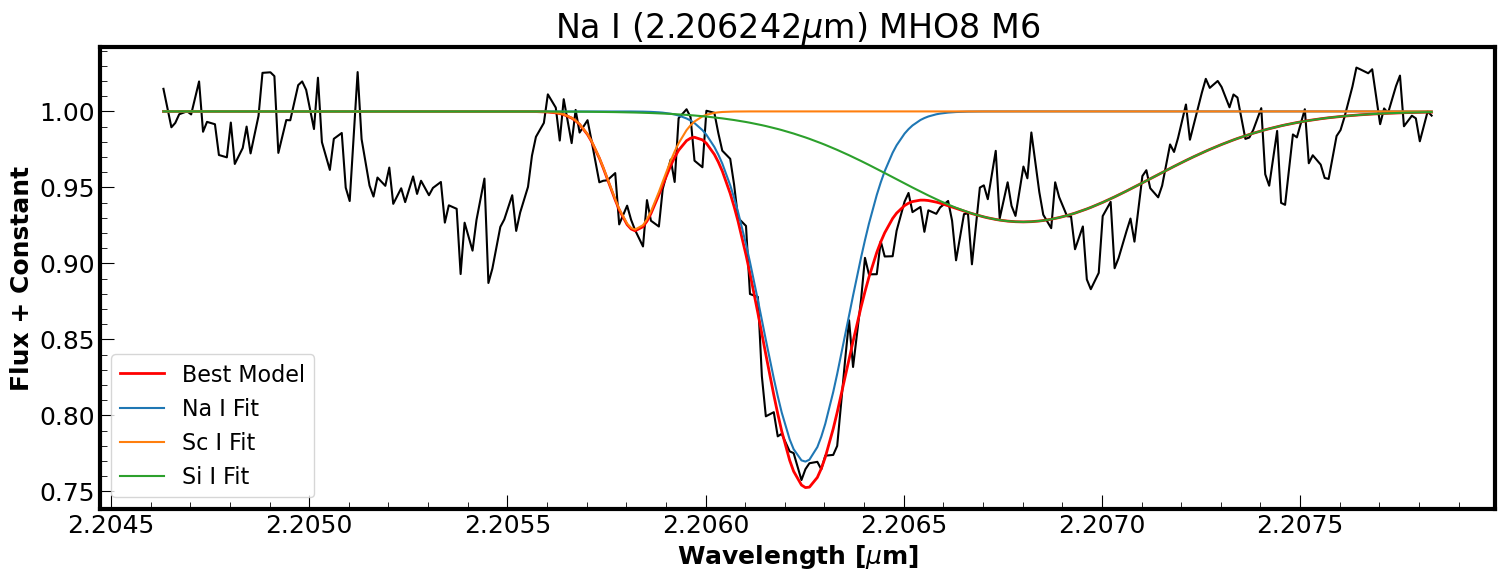

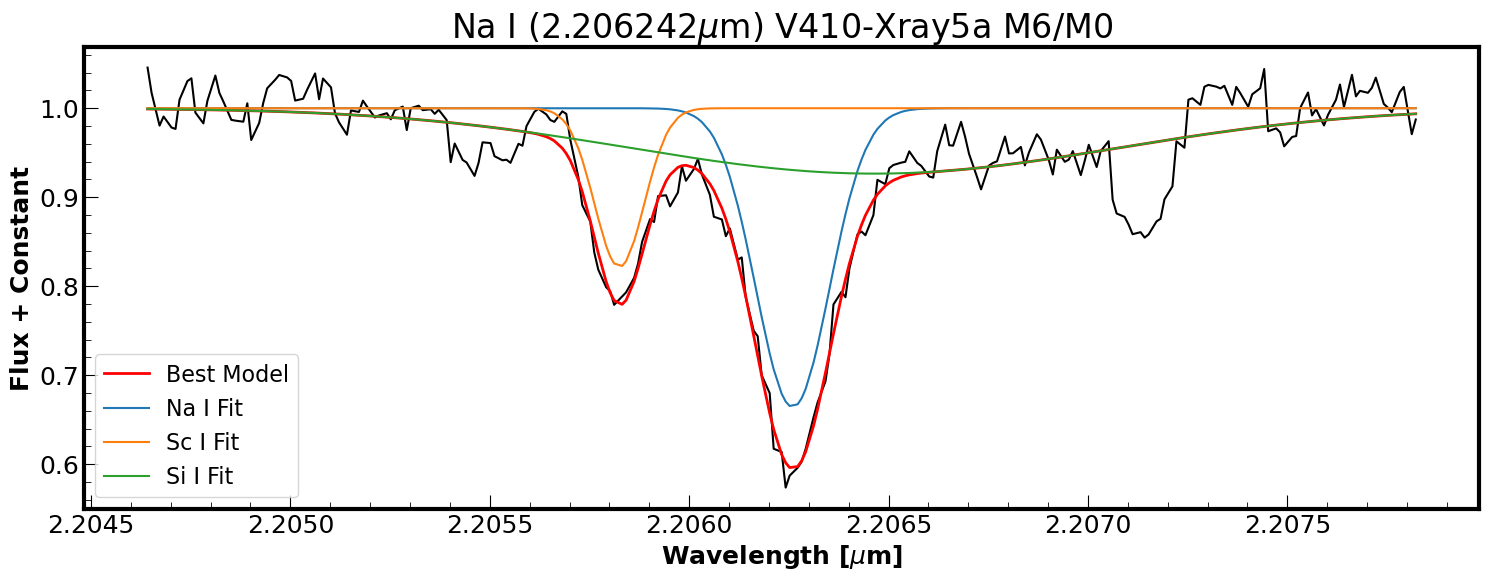

In [13]:
# Define the region for fitting
line_name = lines_table[na1_mask][0]['Spectrum'] # Species
line_center = lines_table[na1_mask][0]['Observed'] # Wavelength

idx1_stack = []
idx2_stack = []
idx3_stack = []
idx4_stack = []

normalized_flux_stack = []
continuum_stack = []

for i in range(len(standard_list)):
    continuum, idx1, idx2, idx3, idx4 = ig.local_continuum_fit(wavelen_stack[:,i],
                                                               raw_flux_stack[:,i],
                                                               1,
                                                               line_center,
                                                               spec_res,
                                                               window_size=10,
                                                               num=150)

    continuum_stack.append(continuum)

    normalized_flux_stack.append(raw_flux_stack[idx1:idx4,i]/continuum)

    idx1_stack.append(idx1)
    idx2_stack.append(idx2)
    idx3_stack.append(idx3)
    idx4_stack.append(idx4)

    # fig = plt.figure(figsize=(12,6))

    # plt.plot(wavelen_stack[idx1:idx4,i],raw_flux_stack[idx1:idx4,i])
    # plt.plot(wavelen_stack[idx1:idx4,i],continuum)

    # plt.axvspan(wavelen_stack[idx1_stack[i],i],wavelen_stack[idx2_stack[i],i],alpha=0.25,color='red')
    # plt.axvspan(wavelen_stack[idx3_stack[i],i],wavelen_stack[idx4_stack[i],i],alpha=0.25,color='red')

    # plt.title(f"{line_name} {line_center} {standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")
    # plt.show()

amplitude1_stack = []
center1_stack = []
sigma1_stack = []

amplitude2_stack = []
center2_stack = []
sigma2_stack = []

amplitude3_stack = []
center3_stack = []
sigma3_stack = []

best_model_stack = []

for i in range(len(standard_list)):
    # Define initial parameters for Gaussian fitting
    init_params = (-0.2, line_center, spec_res,
                   -0.05, 2.2058, spec_res,
                   -0.1, 2.2068, spec_res)

    # Perform Gaussian fitting for the current source
    popt, pcov, best_model = ig.three_gauss_fit(wavelen_stack[idx1_stack[i]:idx4_stack[i],i],
                                        normalized_flux_stack[i],
                                        init_params,
                                        50000)
    
    # Append the best_model and parameters stacks
    amplitude1_stack.append(popt[0])
    center1_stack.append(popt[1])
    sigma1_stack.append(popt[2])

    amplitude2_stack.append(popt[3])
    center2_stack.append(popt[4])
    sigma2_stack.append(popt[5])

    amplitude3_stack.append(popt[6])
    center3_stack.append(popt[7])
    sigma3_stack.append(popt[8])
    
    pcov_stack.append(pcov)
    best_model_stack.append(best_model)

flux_constant = np.linspace(0,1,len(standard_list))
na1_2_2062_fit = []
sc1_2_2058_fit = []
si1_2_2068_fit = []

for i in range(len(standard_list)):

    na1_2_2062_fit.append(ig.gaussian(wavelen_stack[idx1_stack[i]:idx4_stack[i],i],amplitude1_stack[i],center1_stack[i],sigma1_stack[i]))
    sc1_2_2058_fit.append(ig.gaussian(wavelen_stack[idx1_stack[i]:idx4_stack[i],i],amplitude2_stack[i],center2_stack[i],sigma2_stack[i]))
    si1_2_2068_fit.append(ig.gaussian(wavelen_stack[idx1_stack[i]:idx4_stack[i],i],amplitude3_stack[i],center3_stack[i],sigma3_stack[i]))

    fig = plt.figure(figsize=(18,6))

    plt.plot(wavelen_stack[idx1_stack[i]:idx4_stack[i],i],normalized_flux_stack[i], c='black')
    plt.plot(wavelen_stack[idx1_stack[i]:idx4_stack[i],i],best_model_stack[i],c='red',lw=2,label='Best Model')
    # Na I
    plt.plot(wavelen_stack[idx1_stack[i]:idx4_stack[i],i],na1_2_2062_fit[i], label = 'Na I Fit')
    # Sc I 2.2058 (there's another at 2.2071)
    plt.plot(wavelen_stack[idx1_stack[i]:idx4_stack[i],i],sc1_2_2058_fit[i], label = 'Sc I Fit')
    # Si I 2.2068
    plt.plot(wavelen_stack[idx1_stack[i]:idx4_stack[i],i],si1_2_2068_fit[i], label = 'Si I Fit')

    plt.ylabel('Flux + Constant')
    plt.xlabel(r'Wavelength [$\mu$m]')

    plt.title(rf"{line_name} ({line_center}$\mu$m) {standard_table['Name'][i]} {standard_table['Spectral_Type'][i]}")

    plt.legend()
plt.show()

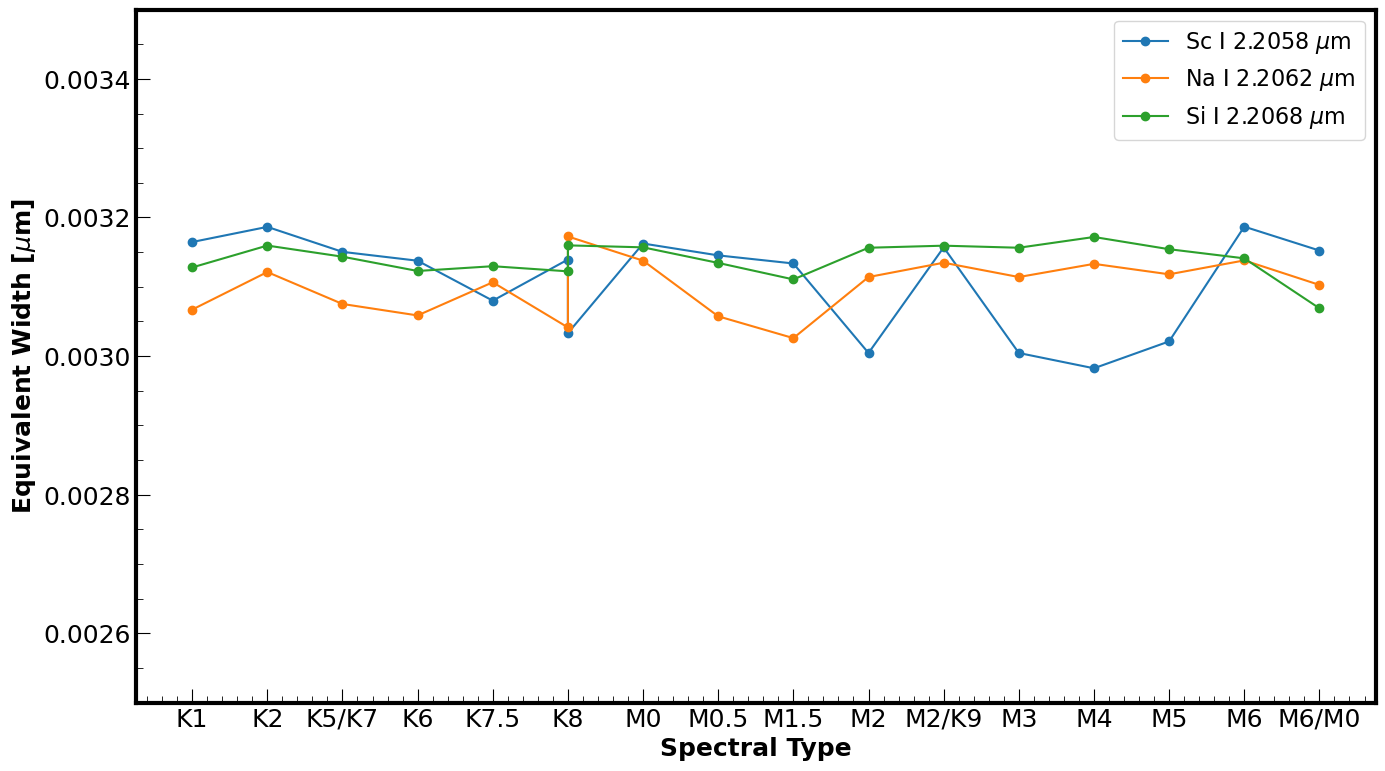

In [23]:
ew1_stack = [] # empty list to load in equivalent widths
ew2_stack = []
ew3_stack = []

for i in range(len(standard_list)):
    ew1 = np.trapz(na1_2_2062_fit[i],wavelen_stack[idx1_stack[i]:idx4_stack[i],i]) # integrate the gaussian
    ew1_stack.append(ew1)

    ew2 = np.trapz(sc1_2_2058_fit[i],wavelen_stack[idx1_stack[i]:idx4_stack[i],i])
    ew2_stack.append(ew2)

    ew3 = np.trapz(si1_2_2068_fit[i],wavelen_stack[idx1_stack[i]:idx4_stack[i],i])
    ew3_stack.append(ew3)
    
standard_table['ew_na1_2_2062'] = ew1_stack
standard_table['ew_sc1_2_2058'] = ew2_stack
standard_table['ew_si1_2_2068'] = ew3_stack

fig = plt.figure(figsize=(16,9))

plt.plot(standard_table['Spectral_Type'], standard_table['ew_sc1_2_2058'],ls='-',marker='o', label=f"Sc I 2.2058 $\mu$m")
plt.plot(standard_table['Spectral_Type'], standard_table['ew_na1_2_2062'],ls='-',marker='o', label=f"Na I 2.2062 $\mu$m")
plt.plot(standard_table['Spectral_Type'], standard_table['ew_si1_2_2068'],ls='-',marker='o', label=f"Si I 2.2068 $\mu$m")

# plt.scatter(standard_table['Spectral_Type'], area_stack)
# plt.ylim(np.nanmedian(ew_stack)+-0.001,np.nanmedian(ew_stack)+0.001)

plt.ylim(0.0025,0.0035)

plt.xlabel('Spectral Type')
plt.ylabel(r'Equivalent Width [$\mu$m]')
# plt.title(f"{line_name} {line_center} $\mu$m")

plt.legend()
plt.show()

In [20]:
standard_table

Source         Name  \
0   C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...     HD286178   
1   C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...        HQTau   
2   C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...       LkCa14   
3   C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...       HBC427   
4   C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...      V830Tau   
5   C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...      Hubble4   
6   C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...   XEST09-042   
7   C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...     Haro6-13   
8   C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...        Anon1   
9   C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...        JH108   
10  C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...        LkCa4   
11  C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...        DKTau   
12  C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...       HBC359   
13  C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...        JH433   
14  C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...         MHO7   
15  C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...         MHO8   
16  C:/Users/Savio/Documents/IGRINS-Spectra/IGRINS...  V410-Xray5a   

   Spectral_Type       v/c  Wavelength Shift  ew_na1_2_2089  ew_na1_2_2062  \
0             K1  0.000108          0.000238       0.000071       0.003067   
1             K2  0.000108          0.000238       0.000052       0.003121   
2          K5/K7  0.000044          0.000098       0.000095       0.003075   
3             K6  0.000099          0.000218       0.000099       0.003059   
4           K7.5  0.000158          0.000348       0.000112       0.003107   
5             K8  0.000040          0.000088       0.000102       0.003041   
6             K8  0.000140          0.000308       0.000117       0.003173   
7             M0  0.000126          0.000278       0.000034       0.003138   
8           M0.5  0.000044          0.000098       0.000100       0.003057   
9           M1.5  0.000094          0.000208       0.000119       0.003026   
10            M2  0.000040          0.000088       0.000136       0.003114   
11         M2/K9  0.000040          0.000088       0.000039       0.003135   
12            M3  0.000040          0.000088       0.000136       0.003114   
13            M4  0.000131          0.000288       0.000090       0.003133   
14            M5  0.000117          0.000258       0.000083       0.003118   
15            M6  0.000140          0.000308       0.000060       0.003138   
16         M6/M0  0.000031          0.000068       0.000095       0.003103   

    ew_sc1_2_2058  ew_si1_2_2068  
0        0.003165       0.003128  
1        0.003186       0.003159  
2        0.003150       0.003143  
3        0.003138       0.003123  
4        0.003080       0.003130  
5        0.003139       0.003122  
6        0.003033       0.003160  
7        0.003162       0.003157  
8        0.003145       0.003134  
9        0.003134       0.003111  
10       0.003004       0.003156  
11       0.003157       0.003159  
12       0.003004       0.003156  
13       0.002982       0.003172  
14       0.003021       0.003154  
15       0.003187       0.003141  
16       0.003152       0.003069

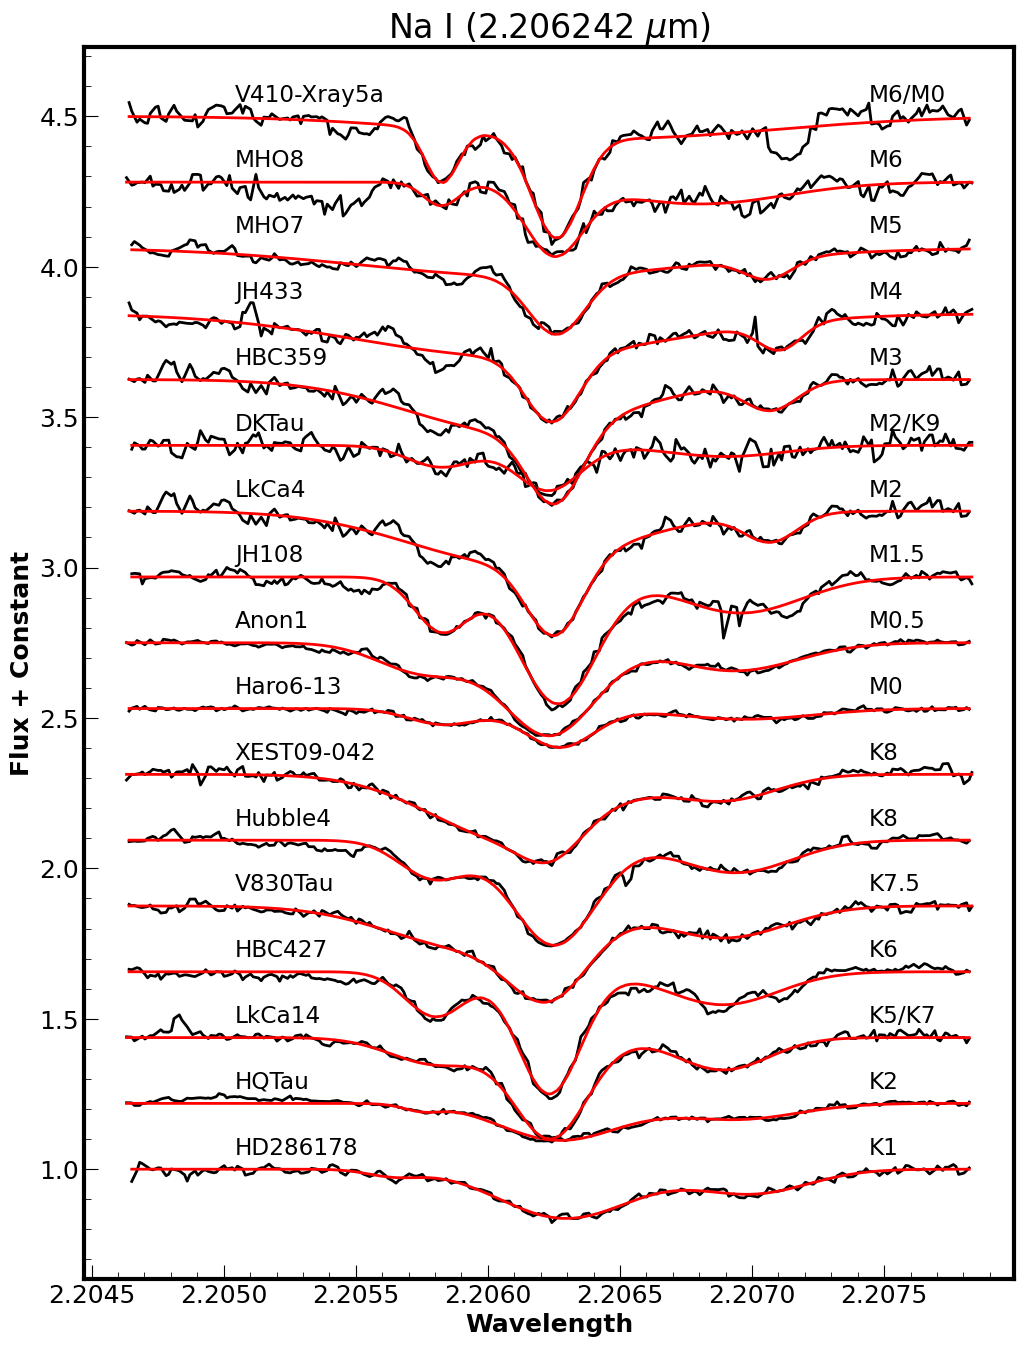

In [9]:
min_wave = line_center - (120 * spec_res)
max_wave = line_center + (120 * spec_res)

flux_constant = np.linspace(0,3.5,len(standard_list))

fig = plt.figure(figsize=(12,16))
for i in range(len(standard_list)):
    plt.plot(wavelen_stack[idx1_stack[i]:idx4_stack[i],i],
             (normalized_flux_stack[i]+flux_constant[i]),
             c='black',lw=2)

    plt.plot(wavelen_stack[idx1_stack[i]:idx4_stack[i],i],
             (best_model_stack[i])+flux_constant[i],
             c='red',lw=2)

    # Source Name Label
    plt.text(min_wave,1.05+flux_constant[i],
            s=f"{standard_table['Name'][i]}",
            fontsize='small')
    # Source Spectral Type Label
    plt.text(max_wave,1.05+flux_constant[i],
             s=f"{standard_table['Spectral_Type'][i]}",
             fontsize='small')

    plt.title(f"{line_name} ({line_center} $\mu$m)")
    plt.ylabel('Flux + Constant')
    plt.xlabel('Wavelength')

plt.show()